In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
#np.seterr(divide='print', invalid='print')
from scipy.sparse import hstack, csr_matrix
from xgboost import XGBClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import IPython
from plotly.offline import init_notebook_mode
%matplotlib inline
import plotly.offline as offline
from sklearn.calibration import CalibratedClassifierCV
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import pickle

from common_functions import *

## Dataset - Loading

In [2]:
train_dataset = pd.read_csv("data/UNSW_NB15_training-set.csv", encoding = "ISO-8859-1")
train_dataset.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [3]:
test_dataset = pd.read_csv("data/UNSW_NB15_testing-set.csv", encoding = "ISO-8859-1")
test_dataset.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [4]:
#taking balanced samples of dataset for training
#reference - https://stackoverflow.com/questions/41035187/stratified-samples-from-pandas

#dataset for training attack classification
train_dataset = train_dataset.groupby('attack_cat').apply(lambda x: x.sample(3000, replace=True))

### Attack Category Classification

#### <font color = 'red'>Attack categorization accuracy can be increased by a 2 stage model in which the first model predicts attack intrusion and then the second model uses this model to predict category of attack </font>

### CV and Test data sharpening

#### Using best performing model from "Intrusion Detection" module to predict "label" field for data

In [5]:
X_train, X_cv, y_train, y_cv = train_test_split(train_dataset.drop(['attack_cat'], axis=1).drop(['id'], axis=1), train_dataset.attack_cat, test_size=0.20)
X_test, y_test = test_dataset.drop(['attack_cat'], axis=1), test_dataset.attack_cat

#taking another Y - whether attack record or not
y_train_1 = X_train.label
y_cv_1 = X_cv.label
y_test_1 = X_test.label

X_train.drop(['label'], axis=1, inplace=True)
X_cv.drop(['label'], axis=1, inplace=True)
X_test.drop(['label'], axis=1, inplace=True)

In [6]:
with open("binary_features", "rb") as fp:   # Unpickling binary features
    binary_features = pickle.load(fp)

with open("categorical_features", "rb") as fp:   # Unpickling categorical features
    categorical_features = pickle.load(fp)

with open("numerical_features", "rb") as fp:   # Unpickling numerical features
    numerical_features = pickle.load(fp)


In [7]:
one_hot_encoders, one_hot_encoders_features = fit_one_hot_encoders(X_train, categorical_features)
feature_standardizers = fit_standard_scalars(X_train, numerical_features)
minmax_scalers = fit_minmax_scalars(X_train, numerical_features)

X_train_encoded, X_train_encoded_features = merge_all(X_train, 
                                                      one_hot_encoders_features, 
                                                      get_one_hot_encoded_features(X_train, categorical_features, one_hot_encoders), 
                                                      get_standardized_features(X_train, numerical_features, feature_standardizers), 
                                                      binary_features)

X_cv_encoded, _ = merge_all(X_cv, one_hot_encoders_features, 
                                                      get_one_hot_encoded_features(X_cv, categorical_features, one_hot_encoders), 
                                                      get_standardized_features(X_cv, numerical_features, feature_standardizers), 
                                                      binary_features)

X_test_encoded, _ = merge_all(X_test, one_hot_encoders_features, 
                                                      get_one_hot_encoded_features(X_test, categorical_features, one_hot_encoders), 
                                                      get_standardized_features(X_test, numerical_features, feature_standardizers), 
                                                      binary_features)

#label encode attack category
y_encoder = LabelEncoder().fit(y_train)
y_train = np.array(y_encoder.transform(y_train))
y_cv = np.array(y_encoder.transform(y_cv))
y_test = np.array(y_encoder.transform(y_test))

#attack categories
print('\n y classes :' + str(y_encoder.classes_))


One Hot Encoding for proto
Feature Names are :
['25', '3pc', 'aes', 'any', 'argus', 'aris', 'arp', 'ax', 'bbn', 'bna', 'br', 'cbt', 'cftp', 'chaos', 'cmtp', 'compaq', 'cphb', 'cpnx', 'crtp', 'crudp', 'dcn', 'ddp', 'ddx', 'dgp', 'egp', 'eigrp', 'emcon', 'enc', 'encap', 'etherip', 'expak', 'fc', 'fire', 'frag', 'ggp', 'gmtp', 'gre', 'hmp', 'iatp', 'ib', 'idp', 'idpr', 'idrp', 'ifmp', 'igmp', 'igp', 'il', 'inp', 'ip', 'ipcomp', 'ipcv', 'ipip', 'iplt', 'ipnip', 'ippc', 'ipv6', 'ipx', 'irtp', 'isis', 'iso', 'kryptolan', 'l2tp', 'larp', 'leaf', 'merit', 'mfe', 'mhrp', 'micp', 'mobile', 'mon', 'mtp', 'mux', 'narp', 'nd', 'netblt', 'nlsp', 'no', 'nsfnet', 'nsp', 'nvp', 'opts', 'ospf', 'peer', 'pgm', 'pim', 'pipe', 'pnni', 'pri', 'prm', 'ptp', 'pup', 'pvp', 'qnx', 'rcc', 'rdp', 'route', 'rpc', 'rsvp', 'rvd', 'sat', 'sccopmce', 'scps', 'sctp', 'sdrp', 'secure', 'sep', 'skip', 'sm', 'smp', 'snp', 'sp3', 'sprite', 'sps', 'srp', 'st2', 'stp', 'sun', 'swipe', 'tcf', 'tcp', 'tlsp', 'tp', 'tp4', 'tru

In [8]:
with open("one_hot_encoders", "wb") as fp:   #Pickling
    pickle.dump(one_hot_encoders, fp)
    
with open("one_hot_encoders_features", "wb") as fp:   #Pickling
    pickle.dump(one_hot_encoders_features, fp)
    
with open("feature_standardizers", "wb") as fp:   #Pickling
    pickle.dump(feature_standardizers, fp)
    
with open("minmax_scalers", "wb") as fp:   #Pickling
    pickle.dump(minmax_scalers, fp)
    
with open("y_encoder", "wb") as fp:   #Pickling
    pickle.dump(y_encoder, fp)

In [9]:
#X_train_encoded = hstack((X_train_encoded, y_train_1.to_numpy().reshape(-1, 1)))

#X_cv_encoded = hstack((X_cv_encoded, y_cv_1_pred.reshape(-1, 1)))
#X_test_encoded = hstack((X_test_encoded, y_test_1_pred.reshape(-1, 1)))
#X_train_encoded_features.append('label')

In [10]:
print(X_train_encoded.shape)
print(X_cv_encoded.shape)
print(X_test_encoded.shape)

(24000, 194)
(6000, 194)
(82332, 194)


In [11]:
"""
    Plot confusion matrix
"""   
def plot_confusion_matrix(y, y_pred):
 
    if np.unique(y).shape[0] == 10:
        labels = y_encoder.classes_
        C = confusion_matrix(y, y_pred)
    else:
        labels = ['Normal', 'Attack']
        C = confusion_matrix(y, y_pred)
    
    
    print("Number of misclassified points ", (len(y)-np.trace(C))/len(y)*100)

    A = (((C.T)/(C.sum(axis=1))).T)    
    B = (C/C.sum(axis=0))
    B[np.isnan(B)] = 0
        
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, fmt=".0f", xticklabels=labels, yticklabels=labels, cmap="YlGnBu")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels, cmap="YlGnBu")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix", B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels, cmap="YlGnBu")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix", A.sum(axis=1))

### Train-Test Split for  Attack Detection

In [12]:
#saving all trained models
model_attack_cat = dict()

#### 0. Random Model

Log loss on Cross Validation Data using Random Model 2.585803571220127
Log loss on Test Data using Random Model 2.59020465520739
Number of misclassified points  89.88364184035369
-------------------------------------------------- Confusion matrix --------------------------------------------------


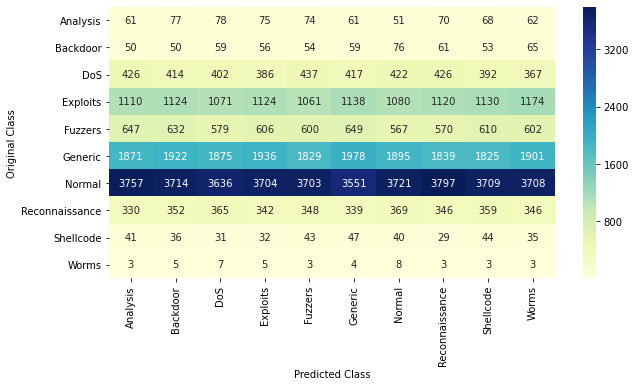

-------------------------------------------------- Precision matrix --------------------------------------------------


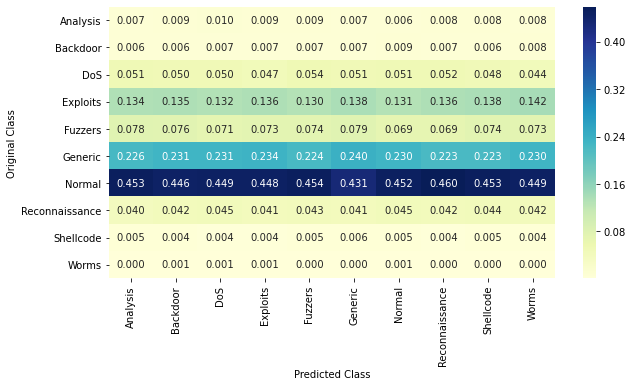

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


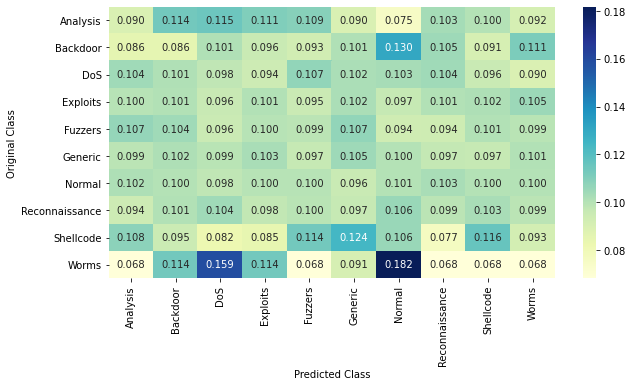

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [13]:
test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

cv_predicted_y = np.zeros((cv_data_len, 10))

for i in range(cv_data_len):
    rand_probs = np.random.rand(1, 10)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv, cv_predicted_y))


# Test-Set error.
test_predicted_y = np.zeros((test_data_len, 10))
for i in range(test_data_len):
    rand_probs = np.random.rand(1, 10)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y))

predicted_y = np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

#### 1. K-Nearest Neigbors

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [11:34<00:00, 99.26s/it]


log_loss for k =  3 is 1.0537659114079563
log_loss for k =  4 is 1.0445618184349699
log_loss for k =  5 is 1.047980475793831
log_loss for k =  6 is 1.046234550336515
log_loss for k =  7 is 1.0448717214786036
log_loss for k =  8 is 1.0459164968003802
log_loss for k =  9 is 1.0476599346824977


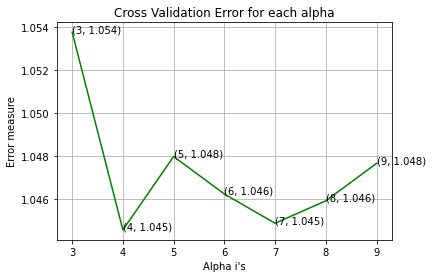

log loss for train data 0.7808340846183567
log loss for cv data 1.0445618184349699
log loss for test data 1.3094655882835131
Number of misclassified points  37.309915950055874
-------------------------------------------------- Confusion matrix --------------------------------------------------


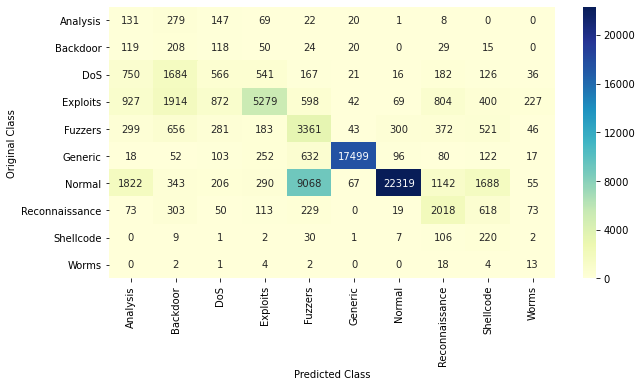

-------------------------------------------------- Precision matrix --------------------------------------------------


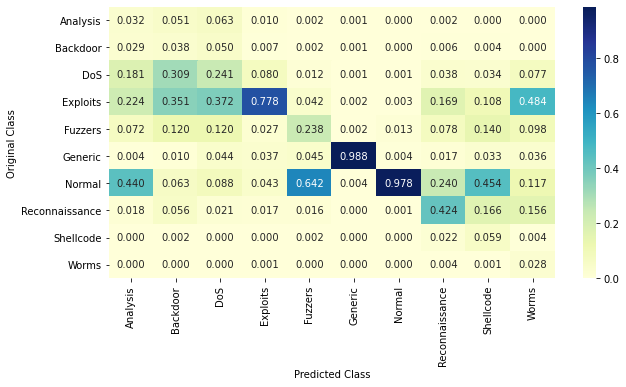

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


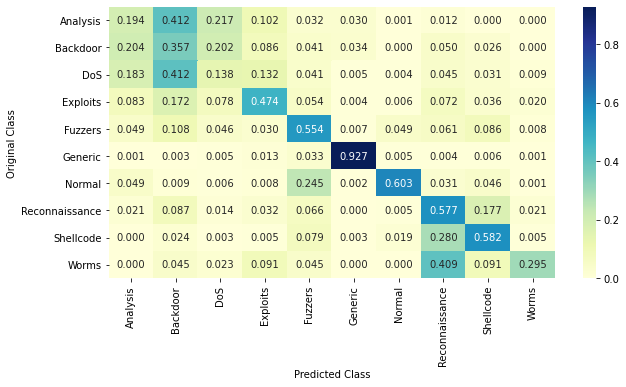

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [14]:
alpha = [x for x in range(3, 10)]
cv_log_error_array=[]
for i in tqdm(alpha):
    k_cfl=KNeighborsClassifier(n_neighbors=i, n_jobs=3)
    k_cfl.fit(X_train_encoded,y_train)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train_encoded, y_train)
    predict_y = sig_clf.predict_proba(X_cv_encoded)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl = KNeighborsClassifier(n_neighbors=alpha[best_alpha], n_jobs=3)
k_cfl.fit(X_train_encoded, y_train)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train_encoded, y_train)
pred_y = sig_clf.predict(X_test_encoded)

predict_y = sig_clf.predict_proba(X_train_encoded)
print ('log loss for train data', log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv_encoded)
print ('log loss for cv data', log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test_encoded)
print ('log loss for test data', log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test_encoded))

#storing trained model
model_attack_cat['knn'] = sig_clf

#### 2. Logistic Regression

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:29<00:00, 17.87s/it]

log_loss for c =  0.0001 is 1.4916682163946413
log_loss for c =  0.0031622776601683794 is 1.3165809355813158
log_loss for c =  0.1 is 1.3161023332846764
log_loss for c =  3.1622776601683795 is 1.4263676024238083
log_loss for c =  100.0 is 1.4449567018999074


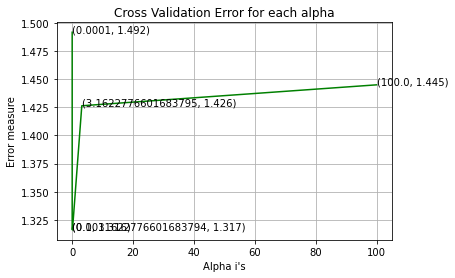

log loss for train data 1.3002768192469265
log loss for cv data 1.3161023332846764
log loss for test data 1.4850693120049445
Number of misclassified points  46.73759898945732
-------------------------------------------------- Confusion matrix --------------------------------------------------


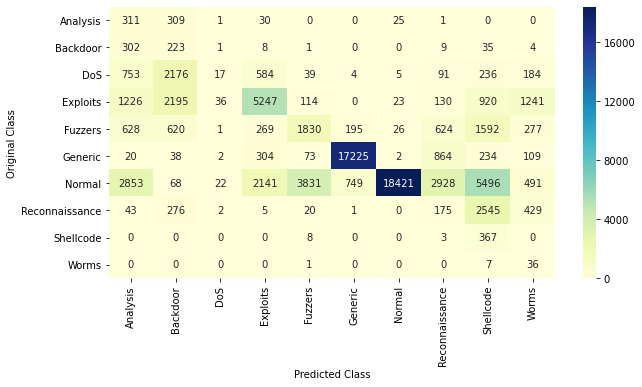

-------------------------------------------------- Precision matrix --------------------------------------------------


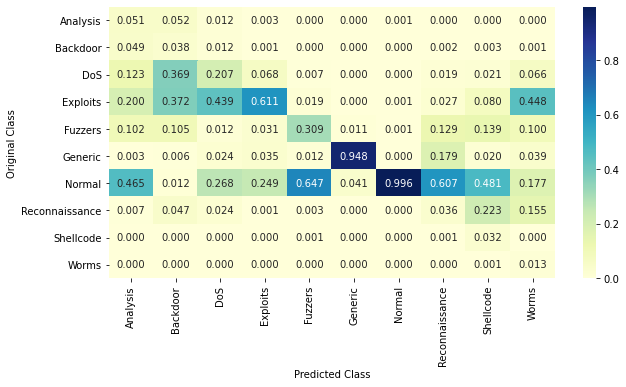

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


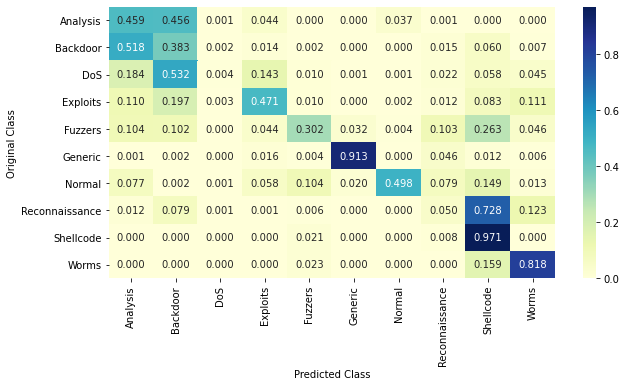

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [15]:
alpha = list(np.logspace(-4, 2, num=5))
cv_log_error_array=[]
for i in tqdm(alpha, position=0, leave=True):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced', n_jobs=3)
    logisticR.fit(X_train_encoded,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train_encoded, y_train)
    predict_y = sig_clf.predict_proba(X_cv_encoded)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced', n_jobs=3)
logisticR.fit(X_train_encoded,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train_encoded, y_train)

predict_y = sig_clf.predict_proba(X_train_encoded)
print ('log loss for train data',(log_loss(y_train, predict_y)))
predict_y = sig_clf.predict_proba(X_cv_encoded)
print ('log loss for cv data',(log_loss(y_cv, predict_y)))
predict_y = sig_clf.predict_proba(X_test_encoded)
print ('log loss for test data',(log_loss(y_test, predict_y)))
plot_confusion_matrix(y_test,sig_clf.predict(X_test_encoded))

#storing trained model
model_attack_cat['lr'] = sig_clf

#### 3. Random Forest

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.90s/it]

log_loss for c =  5 is 0.8337610768052525
log_loss for c =  10 is 0.8178345045161729
log_loss for c =  25 is 0.8101723318813211
log_loss for c =  50 is 0.8103646153081587
log_loss for c =  100 is 0.8076697145429024


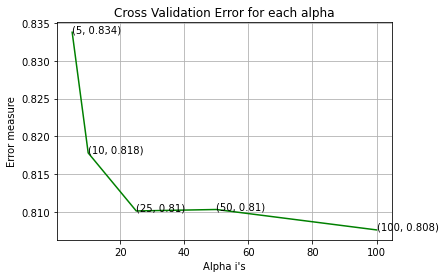

log loss for train data 0.5032293525083406
log loss for cv data 0.8071327775827545
log loss for test data 1.040664080511388
Number of misclassified points  32.779478210173444
-------------------------------------------------- Confusion matrix --------------------------------------------------


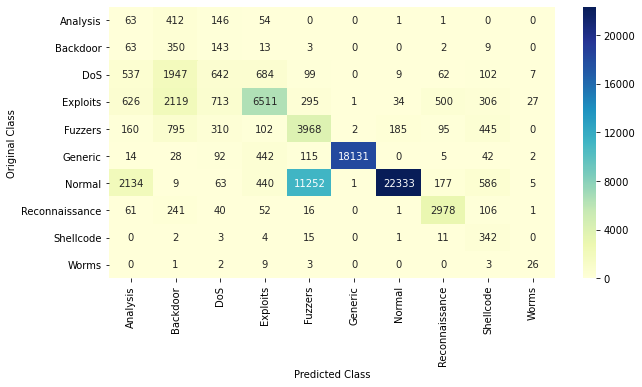

-------------------------------------------------- Precision matrix --------------------------------------------------


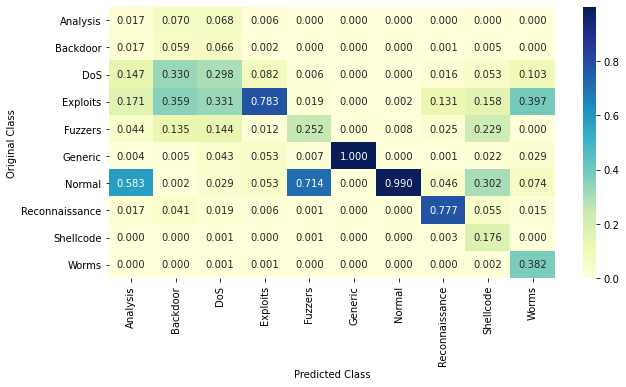

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


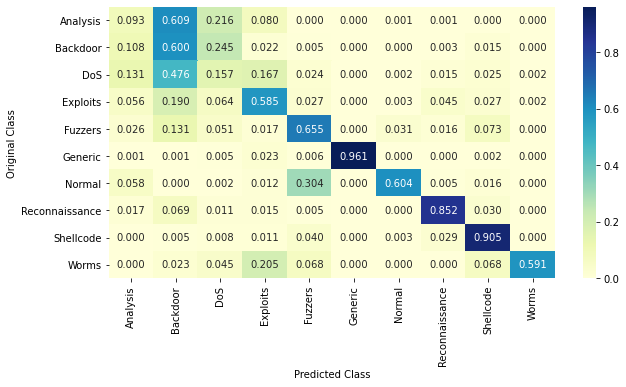

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [16]:
alpha=[5, 10, 25, 50, 100]
cv_log_error_array=[]
for i in tqdm(alpha, position=0, leave=True):
    r_cfl=RandomForestClassifier(n_estimators=i, n_jobs=3)
    r_cfl.fit(X_train_encoded, y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train_encoded, y_train)
    predict_y = sig_clf.predict_proba(X_cv_encoded)
    cv_log_error_array.append(log_loss(y_cv, predict_y))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha], n_jobs=3)
r_cfl.fit(X_train_encoded, y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train_encoded, y_train)
predict_y = sig_clf.predict_proba(X_train_encoded)
print ('log loss for train data',(log_loss(y_train, predict_y)))
predict_y = sig_clf.predict_proba(X_cv_encoded)
print ('log loss for cv data',(log_loss(y_cv, predict_y)))
predict_y = sig_clf.predict_proba(X_test_encoded)
print ('log loss for test data',(log_loss(y_test, predict_y)))
plot_confusion_matrix(y_test, sig_clf.predict(X_test_encoded))

#storing trained model
model_attack_cat['rf'] = sig_clf

### Feature Importance for Random Forest Model

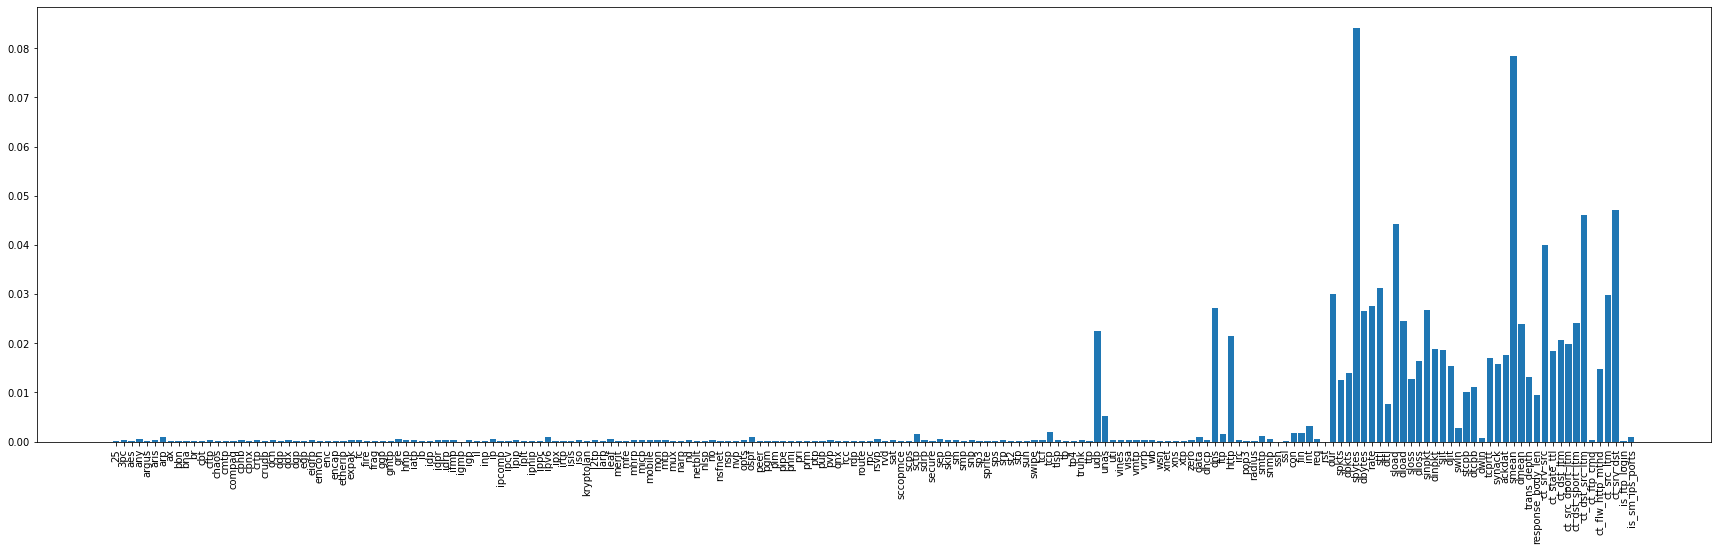

In [17]:
plt.figure(figsize=(30, 8))
plt.xticks(rotation=90)
plt.bar(X_train_encoded_features, model_attack_cat['rf'].base_estimator.feature_importances_)
plt.show()

### Showing top 30 important features

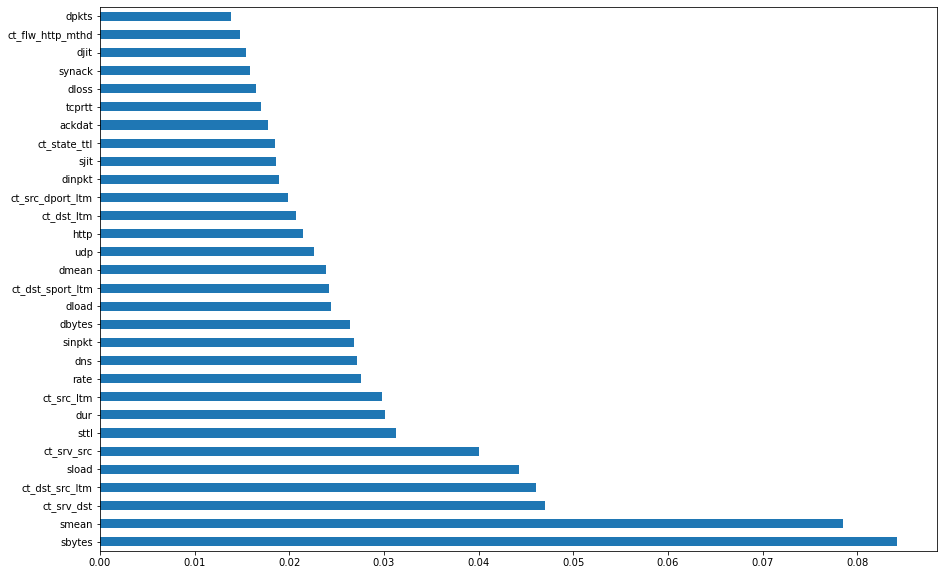

In [18]:
plt.figure(figsize=(15, 10))
pd.Series(model_attack_cat['rf'].base_estimator.feature_importances_, index=X_train_encoded_features).nlargest(30).plot(kind='barh')
plt.show()

#### 4. XGBoost

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [46:45<00:00, 400.82s/it]


log_loss for c =  10 is 0.9562502628145008
log_loss for c =  50 is 0.8275385865924048
log_loss for c =  100 is 0.7756595915890239
log_loss for c =  300 is 0.7406666571781416
log_loss for c =  500 is 0.7325381211364972
log_loss for c =  600 is 0.7317331939037027
log_loss for c =  800 is 0.7313922342040311


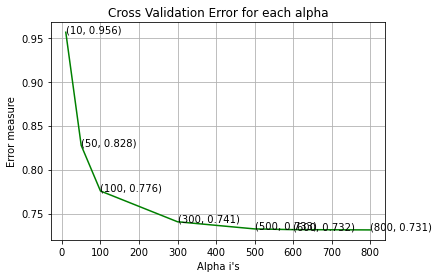

For values of best alpha =  800 The train log loss is: 0.596621144837667
For values of best alpha =  800 The cross validation log loss is: 0.7313922342040311
For values of best alpha =  800 The test log loss is: 1.035050548442805
Number of misclassified points  32.28999659913521
-------------------------------------------------- Confusion matrix --------------------------------------------------


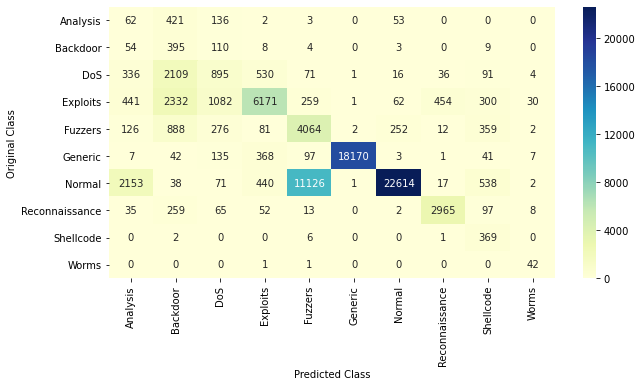

-------------------------------------------------- Precision matrix --------------------------------------------------


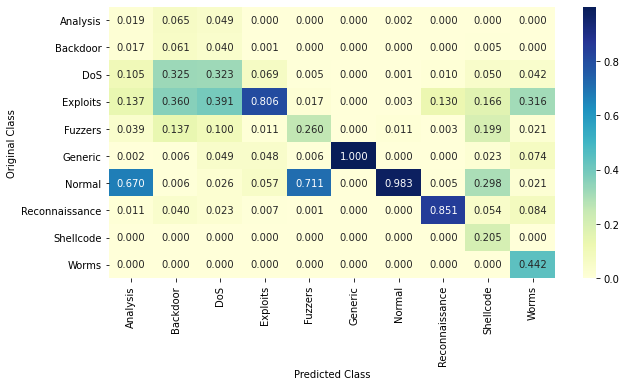

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


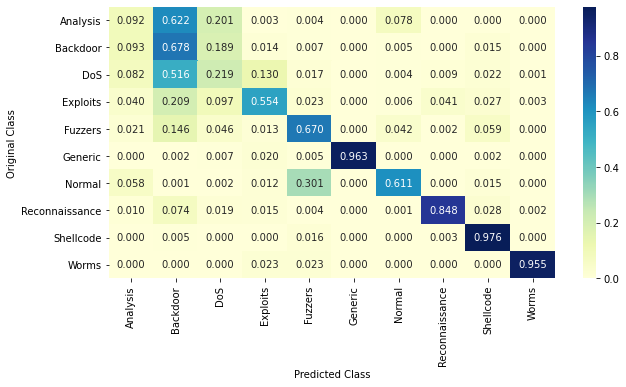

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [19]:
alpha=[10, 50, 100, 300, 500, 600, 800]
cv_log_error_array=[]
for i in tqdm(alpha):
    x_cfl=XGBClassifier(n_estimators=i, nthread=3)
    x_cfl.fit(X_train_encoded, y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_encoded, y_train)
    predict_y = sig_clf.predict_proba(X_cv_encoded)
    cv_log_error_array.append(log_loss(y_cv, predict_y))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
    
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha], nthread=4)
x_cfl.fit(X_train_encoded,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_encoded, y_train)
    
predict_y = sig_clf.predict_proba(X_train_encoded)

print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv_encoded)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test_encoded)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test,sig_clf.predict(X_test_encoded))

#storing trained model
model_attack_cat['xgb'] = sig_clf

In [20]:
with open("best_xgb.dat", "wb") as fp:   #Pickling
    pickle.dump(model_attack_cat['xgb'], fp)

### Feature Importance for XGBoost Model

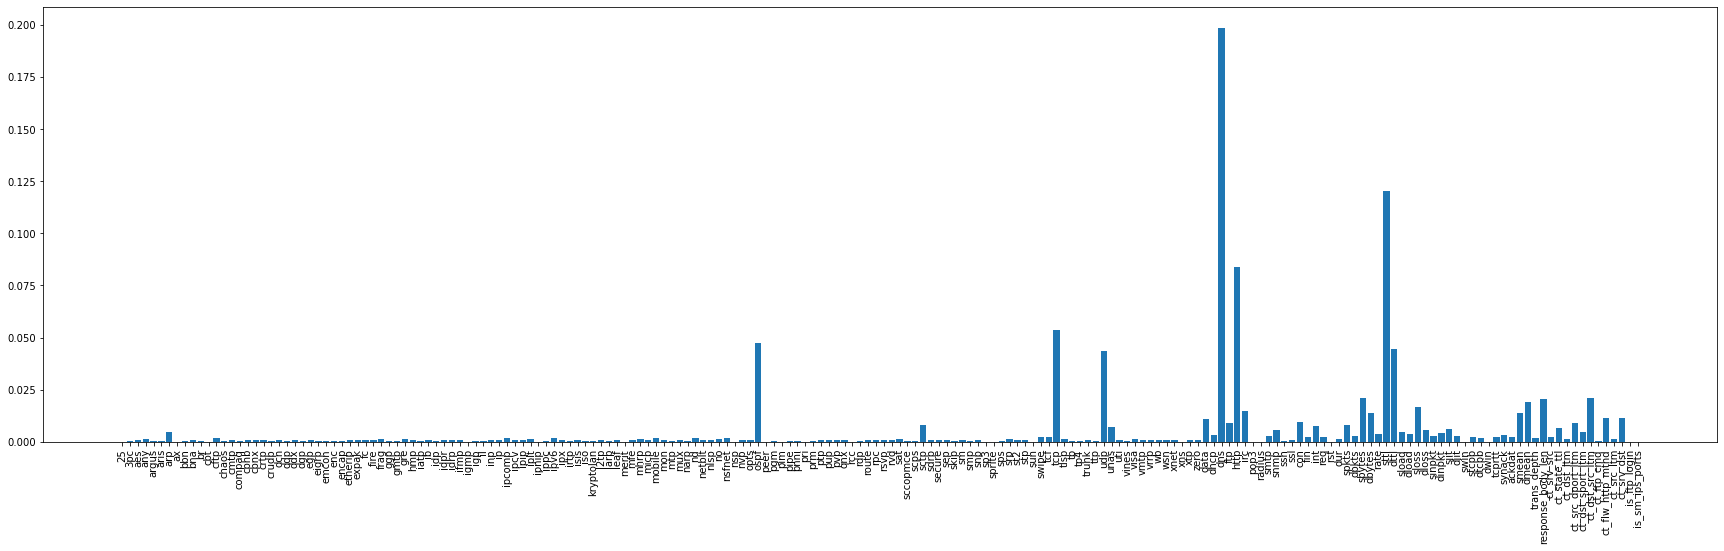

In [21]:
plt.figure(figsize=(30, 8))
plt.xticks(rotation=90)
plt.bar(X_train_encoded_features, model_attack_cat['xgb'].base_estimator.feature_importances_)
plt.show()

### Showing top 50 important features

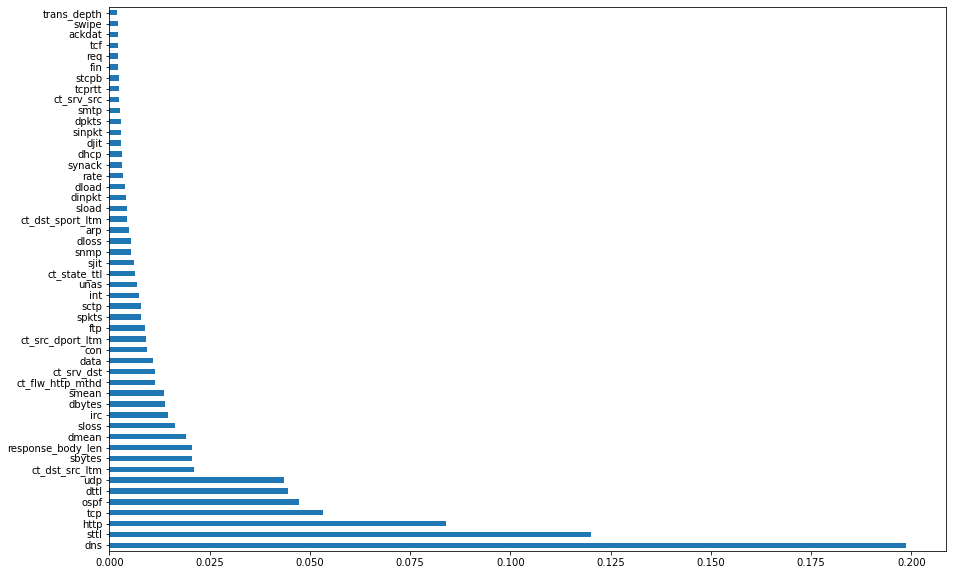

In [22]:
plt.figure(figsize=(15, 10))
pd.Series(model_attack_cat['xgb'].base_estimator.feature_importances_, index=X_train_encoded_features).nlargest(50).plot(kind='barh')
plt.show()

#### 6. Decision Tree

Best Parameters :{'class_weight': 'balanced', 'max_depth': 14, 'min_samples_split': 2}
The train log loss is: 0.5545910410014551
The cross validation log loss is: 1.6927170786499155
The test log loss is: 3.792830311695155
Number of misclassified points  34.642666277996405
-------------------------------------------------- Confusion matrix --------------------------------------------------


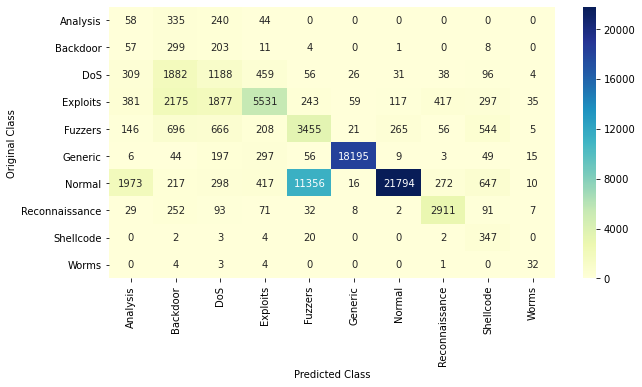

-------------------------------------------------- Precision matrix --------------------------------------------------


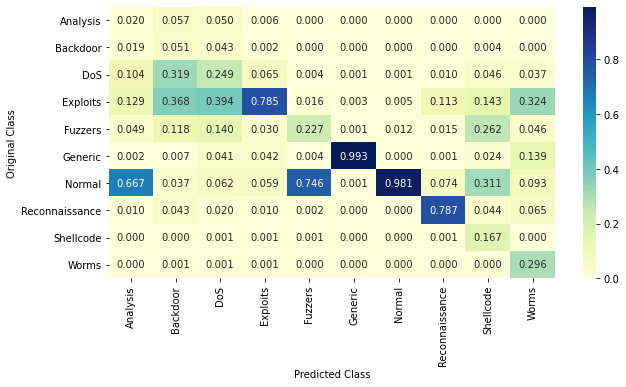

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


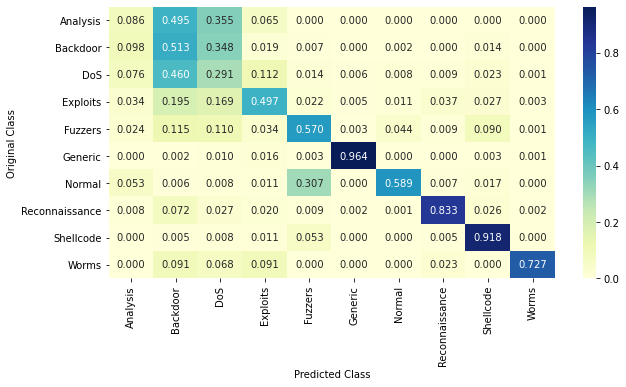

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [23]:
param_grid = {'max_depth': [None, 8, 10, 12, 14], 'class_weight':['balanced'], 'min_samples_split':[2, 3, 4, 6, 10]}

tree = GridSearchCV(DecisionTreeClassifier(), param_grid)
tree.fit(X_train_encoded, y_train)
print('Best Parameters :'+ str(tree.best_params_))
predict_y = tree.predict_proba(X_train_encoded)

print ("The train log loss is:",log_loss(y_train, predict_y))
predict_y = tree.predict_proba(X_cv_encoded)
print("The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = tree.predict_proba(X_test_encoded)
print("The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test,tree.predict(X_test_encoded))

#storing trained model
model_attack_cat['dt'] = tree

#### Feature Importance for Decision Tree

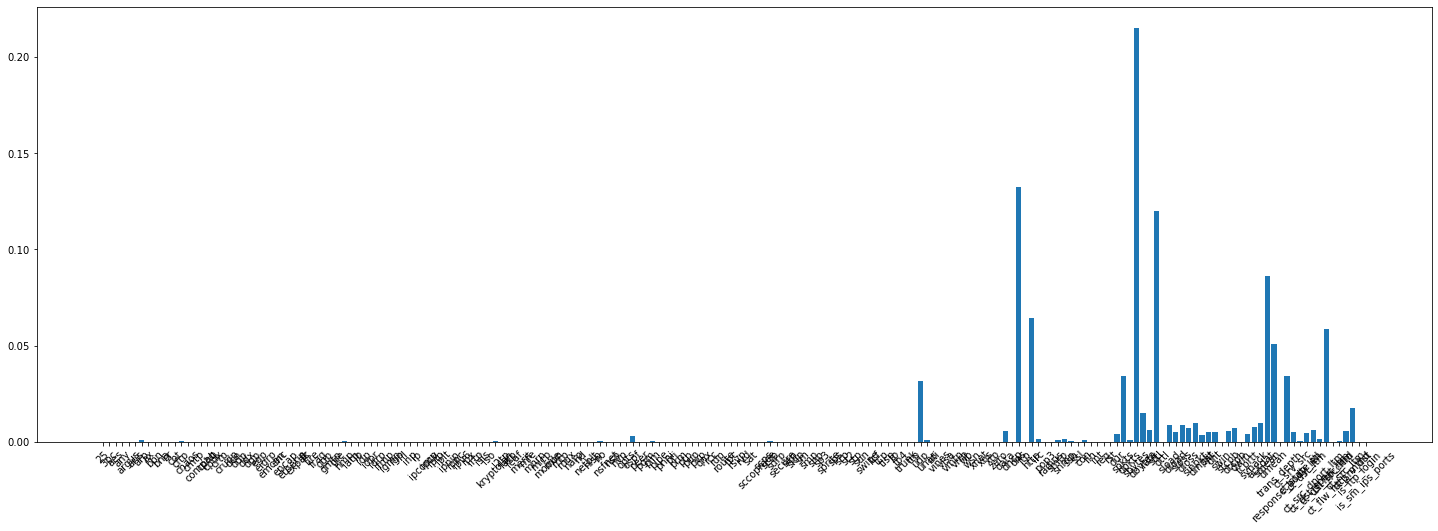

In [24]:
plt.figure(figsize=(25, 8))
plt.xticks(rotation=45)
plt.bar(X_train_encoded_features, model_attack_cat['dt'].best_estimator_.feature_importances_)
plt.show()

### Showing top 30 important features

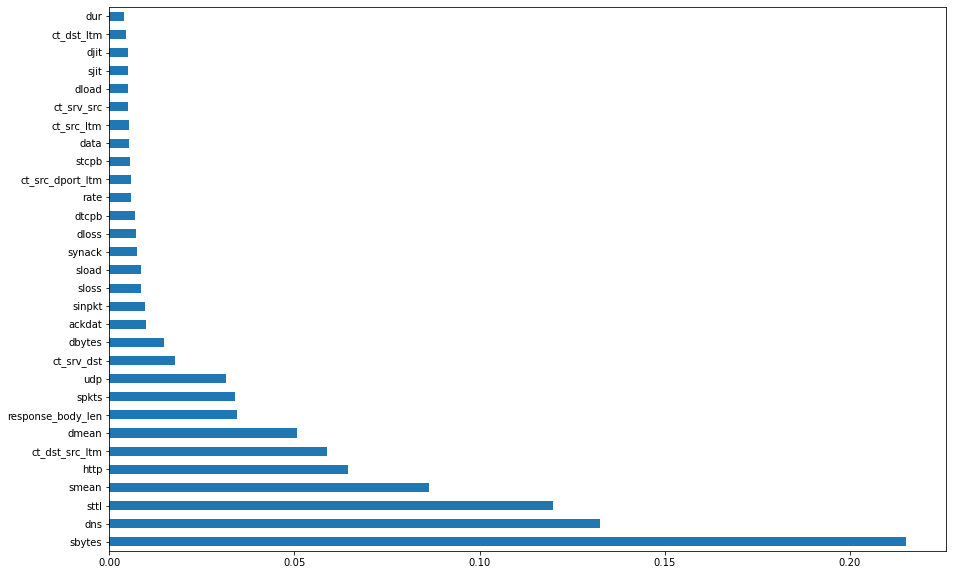

In [25]:
plt.figure(figsize=(15, 10))
pd.Series(model_attack_cat['dt'].best_estimator_.feature_importances_, index=X_train_encoded_features).nlargest(30).plot(kind='barh')
plt.show()

#### 7. Support Vector Machine

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.65s/it]

log_loss for c =  0.0001 is 1.1906535028045764
log_loss for c =  0.0005179474679231213 is 1.2141268134105616
log_loss for c =  0.002682695795279727 is 1.2476160316589102
log_loss for c =  0.013894954943731374 is 1.3872815464962536
log_loss for c =  0.07196856730011521 is 1.5919728503047565
log_loss for c =  0.3727593720314942 is 1.6570423779533108
log_loss for c =  1.9306977288832496 is 1.6236858996997092
log_loss for c =  10.0 is 1.6215203733352022


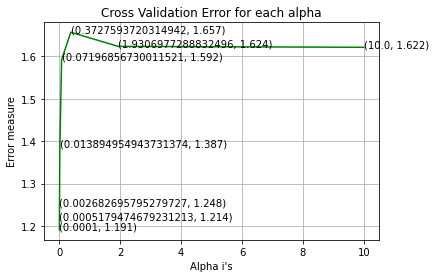

log loss for train data 1.1910167485464414
log loss for cv data 1.20290022240385
log loss for test data 1.1326621643483787
Number of misclassified points  39.57392022542875
-------------------------------------------------- Confusion matrix --------------------------------------------------


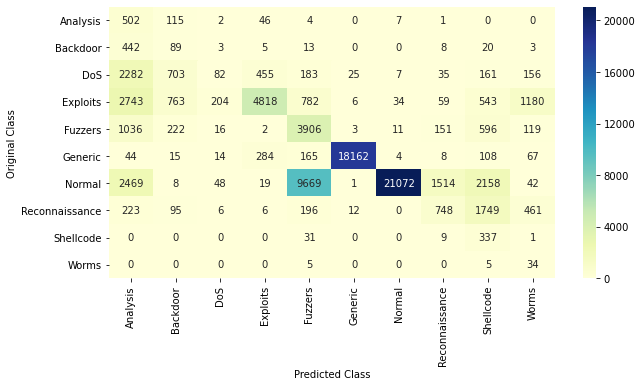

-------------------------------------------------- Precision matrix --------------------------------------------------


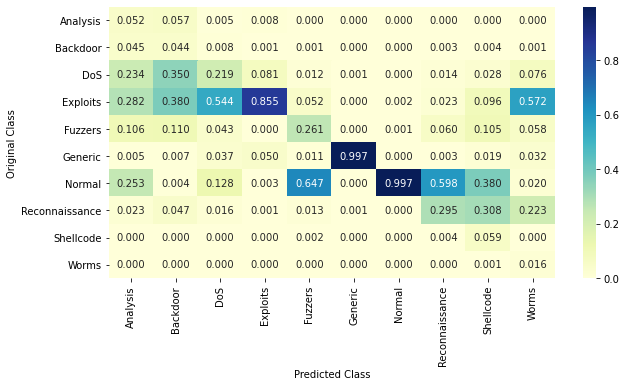

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


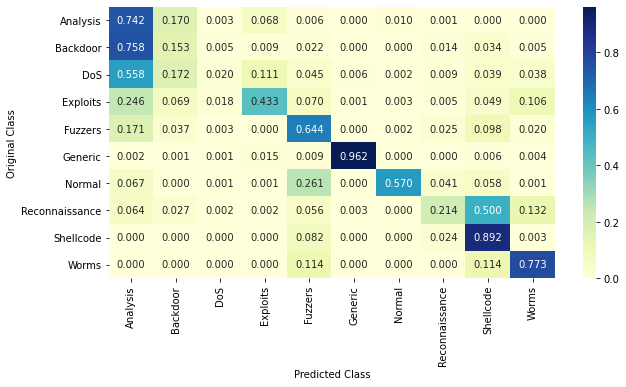

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [26]:
from sklearn.linear_model import SGDClassifier

alpha = list(np.logspace(-4, 1, 8))
cv_log_error_array=[]
for i in tqdm(alpha, position=0, leave=True):
    svm=SGDClassifier(alpha=i, class_weight='balanced', n_jobs=3)
    svm.fit(X_train_encoded,y_train)
    sig_clf = CalibratedClassifierCV(svm, method="sigmoid")
    sig_clf.fit(X_train_encoded, y_train)
    predict_y = sig_clf.predict_proba(X_cv_encoded)
    cv_log_error_array.append(log_loss(y_cv, predict_y))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt, 3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

svm=SGDClassifier(alpha=alpha[best_alpha], class_weight='balanced', n_jobs=3)
svm.fit(X_train_encoded,y_train)
sig_clf = CalibratedClassifierCV(svm, method="sigmoid")
sig_clf.fit(X_train_encoded, y_train)

predict_y = sig_clf.predict_proba(X_train_encoded)
print ('log loss for train data',(log_loss(y_train, predict_y)))
predict_y = sig_clf.predict_proba(X_cv_encoded)
print ('log loss for cv data',(log_loss(y_cv, predict_y)))
predict_y = sig_clf.predict_proba(X_test_encoded)
print ('log loss for test data',(log_loss(y_test, predict_y)))
plot_confusion_matrix(y_test,sig_clf.predict(X_test_encoded))

#storing trained model
model_attack_cat['svm'] = sig_clf

#### 8. Neural Network

In [27]:
model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=X_train_encoded.shape[1]))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint("best_model.hdf5", monitor = "val_loss", mode='min', save_best_only=True, verbose = 1)

model.fit(X_train_encoded.todense(), pd.get_dummies(y_train).values, batch_size=64, epochs=25, validation_data=(X_cv_encoded.todense(), pd.get_dummies(y_cv).values), callbacks=[model_checkpoint])

model = load_model('best_model.hdf5')
#storing trained model
model_attack_cat['nn'] = model

Train on 24000 samples, validate on 6000 samples
Epoch 1/25
23680/24000 [============================>.] - ETA: 0s - loss: 1.1428 - accuracy: 0.5627
Epoch 00001: val_loss improved from inf to 1.03387, saving model to best_model.hdf5
24000/24000 [==============================] - 5s 197us/sample - loss: 1.1426 - accuracy: 0.5624 - val_loss: 1.0339 - val_accuracy: 0.5833
Epoch 2/25
23616/24000 [============================>.] - ETA: 0s - loss: 0.9858 - accuracy: 0.6071
Epoch 00002: val_loss improved from 1.03387 to 0.94160, saving model to best_model.hdf5
24000/24000 [==============================] - 4s 153us/sample - loss: 0.9871 - accuracy: 0.6068 - val_loss: 0.9416 - val_accuracy: 0.6257
Epoch 3/25
23808/24000 [============================>.] - ETA: 0s - loss: 0.9167 - accuracy: 0.6348
Epoch 00003: val_loss improved from 0.94160 to 0.88908, saving model to best_model.hdf5
24000/24000 [==============================] - 4s 162us/sample - loss: 0.9166 - accuracy: 0.6354 - val_loss: 0.88

In [28]:
predict_y = model.predict_proba(X_train_encoded.todense())
print ('log loss for train data', (log_loss(y_train, predict_y, eps=1e-7)))
predict_y = model.predict_proba(X_cv_encoded.todense())
print ('log loss for cv data', (log_loss(y_cv, predict_y, eps=1e-7)))
predict_y = model.predict_proba(X_test_encoded.todense())
print ('log loss for test data', (log_loss(y_test, predict_y, eps=1e-7)))

log loss for train data 0.6912781056648999
log loss for cv data 0.7882256325236158
log loss for test data 1.0103328135408705


Number of misclassified points  35.70422193071953
-------------------------------------------------- Confusion matrix --------------------------------------------------


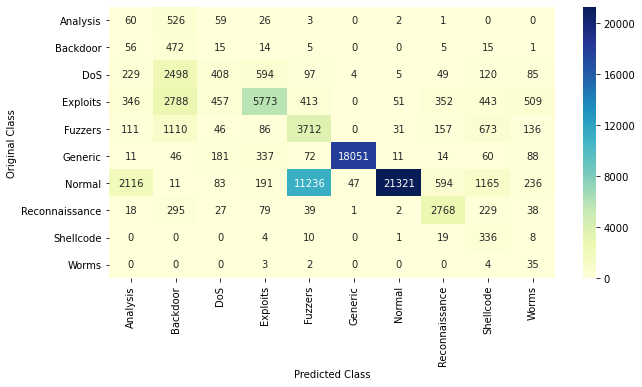

-------------------------------------------------- Precision matrix --------------------------------------------------


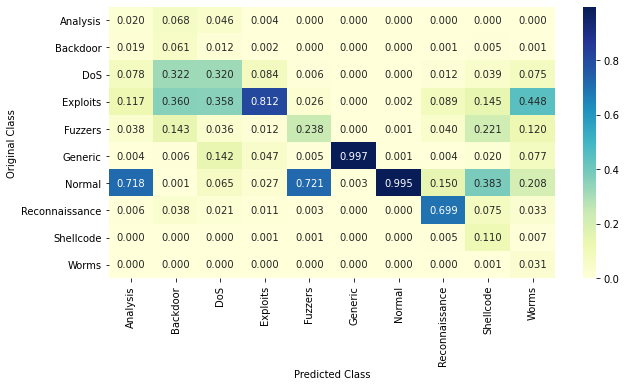

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


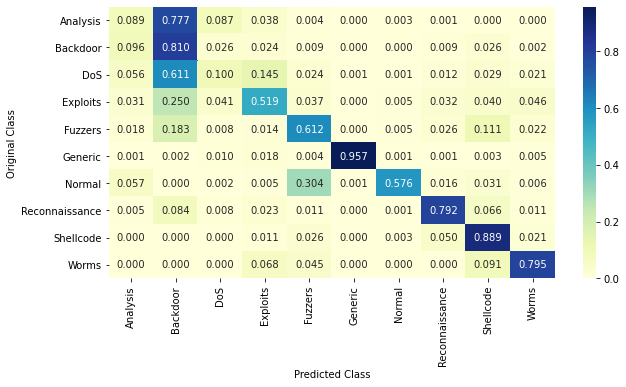

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [29]:
plot_confusion_matrix(y_test, [np.argmax(x) for x in model.predict(X_test_encoded.todense())])

In [30]:
# based on description given in https://www.researchgate.net/publication/332100759_Intrusion_Detection_Using_Big_Data_and_Deep_Learning_Techniques
model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=X_train_encoded.shape[1]))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint("best_model_3hl.hdf5", monitor = "val_loss", mode='min', save_best_only=True, verbose = 1)

model.fit(X_train_encoded.todense(), pd.get_dummies(y_train).values, batch_size=64, epochs=25, validation_data=(X_cv_encoded.todense(), pd.get_dummies(y_cv).values), callbacks=[model_checkpoint])

model = load_model('best_model_3hl.hdf5')
#storing trained model
model_attack_cat['nn'] = model

Train on 24000 samples, validate on 6000 samples
Epoch 1/25
23936/24000 [============================>.] - ETA: 0s - loss: 1.1454 - accuracy: 0.5549
Epoch 00001: val_loss improved from inf to 1.02498, saving model to best_model_3hl.hdf5
24000/24000 [==============================] - 7s 288us/sample - loss: 1.1453 - accuracy: 0.5551 - val_loss: 1.0250 - val_accuracy: 0.5727
Epoch 2/25
23872/24000 [============================>.] - ETA: 0s - loss: 0.9738 - accuracy: 0.6100
Epoch 00002: val_loss improved from 1.02498 to 0.89582, saving model to best_model_3hl.hdf5
24000/24000 [==============================] - 7s 293us/sample - loss: 0.9740 - accuracy: 0.6102 - val_loss: 0.8958 - val_accuracy: 0.6410
Epoch 3/25
23808/24000 [============================>.] - ETA: 0s - loss: 0.9062 - accuracy: 0.6376
Epoch 00003: val_loss improved from 0.89582 to 0.86135, saving model to best_model_3hl.hdf5
24000/24000 [==============================] - 7s 293us/sample - loss: 0.9061 - accuracy: 0.6378 - va

In [31]:
predict_y = model.predict_proba(X_train_encoded.todense())
print ('log loss for train data', (log_loss(y_train, predict_y, eps=1e-7)))
predict_y = model.predict_proba(X_cv_encoded.todense())
print ('log loss for cv data', (log_loss(y_cv, predict_y, eps=1e-7)))
predict_y = model.predict_proba(X_test_encoded.todense())
print ('log loss for test data', (log_loss(y_test, predict_y, eps=1e-7)))

log loss for train data 0.6828950069831499
log loss for cv data 0.7775567032844246
log loss for test data 0.9914881684879555


Number of misclassified points  36.084390030607786
-------------------------------------------------- Confusion matrix --------------------------------------------------


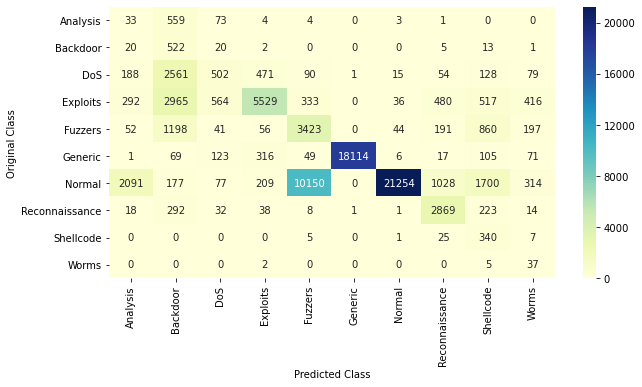

-------------------------------------------------- Precision matrix --------------------------------------------------


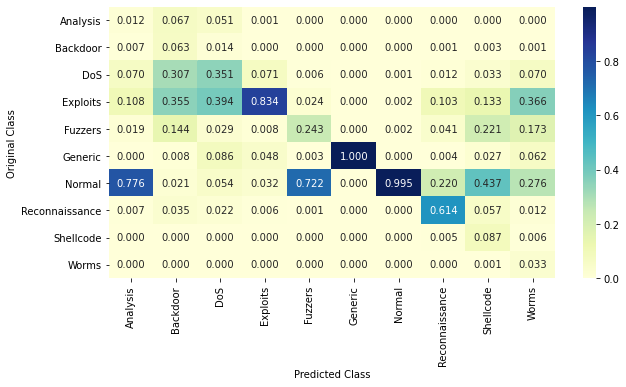

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


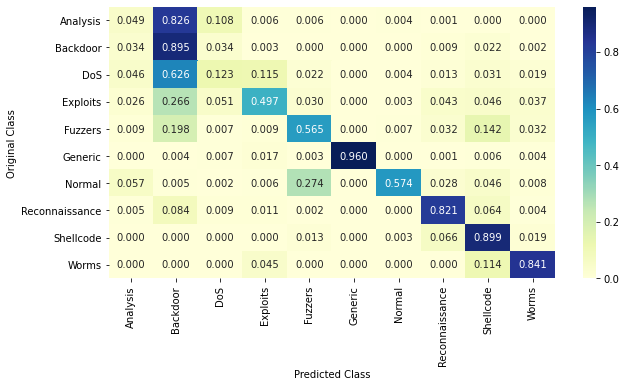

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [32]:
plot_confusion_matrix(y_test, [np.argmax(x) for x in model.predict(X_test_encoded.todense())])

### One Vs Rest

#### 1. XGBoost based OneVsRest Model

In [33]:
class OvrXgb:

    def __init__(self):
        self.ovr_models = dict()
        self.weight = dict()
        for i in range(10):
            self.weight[i] = 1
            
    """
        set new weights
    """
    def set_weight(self, new_weight):
        self.weight = new_weight
    
    """
        train model and validate
    """
    def fit(self, train_x, train_y, val_x, val_y, balance=False):
        ovr_classes = np.unique(train_y)
        print('Training...')
        for ovr_class in ovr_classes:
            self.__fit_class(ovr_class, train_x, train_y, val_x, val_y, balance)


    def __fit_class(self, ovr_class, train_x, train_y, val_x, val_y, balance):
        #train_y_ovr = np.array([1 if y == ovr_class else 0 for y in train_y])
        train_y_ovr = []
        val_y_ovr = np.array([1 if y == ovr_class else 0 for y in val_y])

        #classes of value 1 will be quite less since all other classes will get covered under 0. this might create imbalanced training set
        #generating a balanced training and val subset
        train_mask = []
        val_mask = []

        ovr_class_count = 0
        non_ovr_class_count = 0
        for index, y in enumerate(train_y):
            if y == ovr_class:   #if current class then add directly
                train_mask.append(index)
                train_y_ovr.append(1)
                ovr_class_count+=1
            elif not balance: #if not balance then add directly else add only if balanced
                train_mask.append(index)
                train_y_ovr.append(0)
                non_ovr_class_count+=1
            elif ovr_class_count >= non_ovr_class_count:
                train_mask.append(index)
                train_y_ovr.append(0)
                non_ovr_class_count+=1
        
        x_cfl=XGBClassifier(n_estimators=300, nthread=4)
        x_cfl.fit(train_x[train_mask], train_y_ovr)

        model = CalibratedClassifierCV(x_cfl, method="sigmoid")
        model.fit(train_x[train_mask], train_y_ovr)
        
        self.ovr_models[ovr_class] = model #store OVR model

        train_ovr_detection_acc = self.__get_acc(train_y_ovr, [int(np.round(x)) for x in model.predict(train_x[train_mask])])
        val_ovr_detection_acc = self.__get_acc(val_y_ovr, [int(np.round(x)) for x in model.predict(val_x)])

        print('Accuracy for class "' + str(y_encoder.classes_[ovr_class]) + '" - Train acc.: ' + str(train_ovr_detection_acc) + ' %, Val acc.: ' + str(val_ovr_detection_acc) + ' %')


    """
        get accuracy
    """
    def __get_acc(self, true_y, pred_y):
        return round(accuracy_score(true_y, pred_y) * 100, 2)

    """
        get auc score
    """
    def __get_auc(self, true_y, pred_y):
        return round(roc_auc_score(true_y, pred_y) * 100, 2)


    """
        predict test X
    """
    def predict(self, test_x):
        ovr_pred = np.array([])  #for storing predictions
        ovr_proba = np.array([]) #for storing probabilities
        for ovr_class in np.unique(y_train):
            
            if ovr_class==0:
                ovr_pred, ovr_proba = self.__predict_using_ovr(ovr_class, test_x)
                ovr_proba = ovr_proba * self.weight[ovr_class]
            else:
                pred, proba = self.__predict_using_ovr(ovr_class, test_x)
                proba = proba * self.weight[ovr_class]

                ovr_pred = np.hstack((ovr_pred, pred))
                ovr_proba = np.hstack((ovr_proba, proba))

        result = []
        for index, pred_row in enumerate(ovr_pred):
            #if single prediction is present across all predictions go for this value otherwise use probabilites
            if np.bincount(pred_row.astype(int), minlength=2)[1] == 1:
                result.append(np.argmax(ovr_pred[index]))
            else:
                result.append(np.argmax(ovr_proba[index]))

        return np.array(result)
    
    
    """
        predict probability
    """
    def predict_proba(self, test_x):
        ovr_pred = np.array([])  #for storing predictions
        ovr_proba = np.array([]) #for storing probabilities
        for ovr_class in np.unique([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
            
            if ovr_class==0:
                ovr_pred, ovr_proba = self.__predict_using_ovr(ovr_class, test_x)
                ovr_proba = ovr_proba * self.weight[ovr_class]
            else:
                pred, proba = self.__predict_using_ovr(ovr_class, test_x)
                proba = proba * self.weight[ovr_class]

                ovr_pred = np.hstack((ovr_pred, pred))
                ovr_proba = np.hstack((ovr_proba, proba))

        return ovr_proba

    """
        utility method
    """
    def __predict_using_ovr(self, ovr_class, test_x):
        ovr_model = self.ovr_models[ovr_class]

        """
            use predict
            if it fails then use proba
        """
        pred = ovr_model.predict(test_x)
        #proba = ovr_model.predict_proba(test_x) #use for keras models
        proba = ovr_model.predict_proba(test_x)[:, 1] #use for xgb
        return pred.reshape(-1, 1), proba.reshape(-1, 1)


__OVR XGBoost WITHOUT class balancing__

In [34]:
oxgb = OvrXgb()
oxgb.fit(X_train_encoded.todense(), y_train, X_cv_encoded.todense(), y_cv, False) #trying xgb without balancing
model_attack_cat['oxgb'] = oxgb

Training...
Accuracy for class "Analysis" - Train acc.: 92.75 %, Val acc.: 91.97 %
Accuracy for class "Backdoor" - Train acc.: 91.67 %, Val acc.: 91.0 %
Accuracy for class "DoS" - Train acc.: 90.74 %, Val acc.: 89.7 %
Accuracy for class "Exploits" - Train acc.: 93.31 %, Val acc.: 93.27 %
Accuracy for class "Fuzzers" - Train acc.: 96.49 %, Val acc.: 96.43 %
Accuracy for class "Generic" - Train acc.: 99.88 %, Val acc.: 99.82 %
Accuracy for class "Normal" - Train acc.: 98.59 %, Val acc.: 98.08 %
Accuracy for class "Reconnaissance" - Train acc.: 97.72 %, Val acc.: 97.43 %
Accuracy for class "Shellcode" - Train acc.: 99.18 %, Val acc.: 98.93 %
Accuracy for class "Worms" - Train acc.: 99.99 %, Val acc.: 99.95 %


In [35]:
predict_y = oxgb.predict_proba(X_train_encoded.todense())
print ('log loss for train data', (log_loss(y_train, predict_y)))
predict_y = oxgb.predict_proba(X_cv_encoded)
print ('log loss for cv data', (log_loss(y_cv, predict_y)))
predict_y = oxgb.predict_proba(X_test_encoded)
print ('log loss for test data', (log_loss(y_test, predict_y)))

log loss for train data 0.661506569306046
log loss for cv data 0.7420795315972336
log loss for test data 1.0063642872319776


Number of misclassified points  32.88757712675509
-------------------------------------------------- Confusion matrix --------------------------------------------------


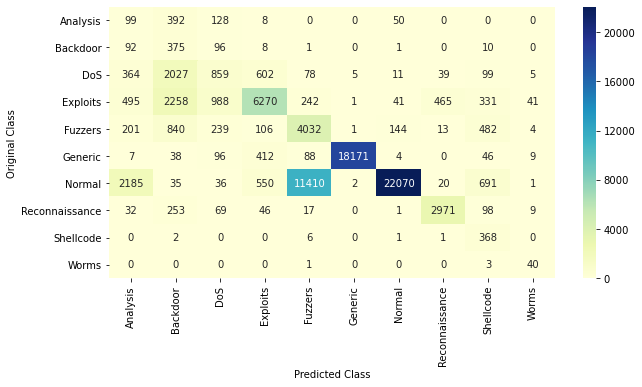

-------------------------------------------------- Precision matrix --------------------------------------------------


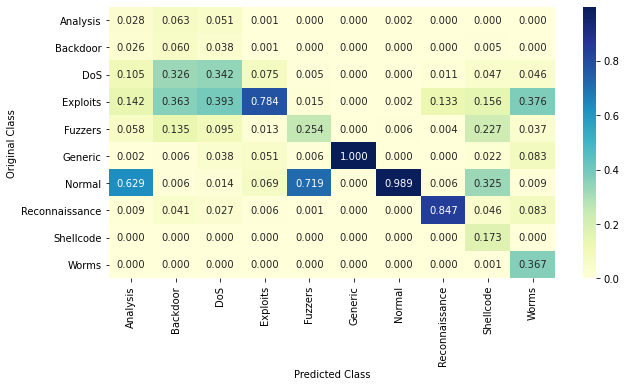

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


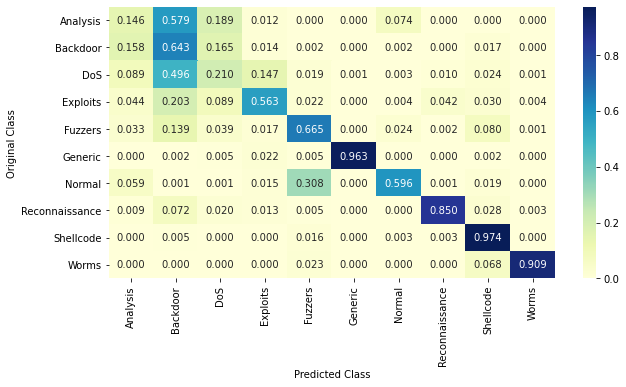

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [36]:
plot_confusion_matrix(y_test, oxgb.predict(X_test_encoded.todense()))

__OVR XGBoost WITH class balancing__

In [37]:
oxgb_balanced = OvrXgb()
oxgb_balanced.fit(X_train_encoded.todense(), y_train, X_cv_encoded.todense(), y_cv, True) #trying xgb with balancing
model_attack_cat['oxgb_balanced'] = oxgb_balanced

Training...
Accuracy for class "Analysis" - Train acc.: 88.09 %, Val acc.: 78.97 %
Accuracy for class "Backdoor" - Train acc.: 87.24 %, Val acc.: 77.42 %
Accuracy for class "DoS" - Train acc.: 84.57 %, Val acc.: 74.52 %
Accuracy for class "Exploits" - Train acc.: 85.34 %, Val acc.: 73.93 %
Accuracy for class "Fuzzers" - Train acc.: 93.73 %, Val acc.: 94.42 %
Accuracy for class "Generic" - Train acc.: 99.6 %, Val acc.: 99.7 %
Accuracy for class "Normal" - Train acc.: 98.15 %, Val acc.: 94.62 %
Accuracy for class "Reconnaissance" - Train acc.: 92.5 %, Val acc.: 93.75 %
Accuracy for class "Shellcode" - Train acc.: 99.51 %, Val acc.: 98.3 %
Accuracy for class "Worms" - Train acc.: 99.98 %, Val acc.: 99.68 %


In [38]:
predict_y = oxgb_balanced.predict_proba(X_train_encoded)
print ('log loss for train data', (log_loss(y_train, predict_y)))
predict_y = oxgb_balanced.predict_proba(X_cv_encoded)
print ('log loss for cv data', (log_loss(y_cv, predict_y)))
predict_y = oxgb_balanced.predict_proba(X_test_encoded)
print ('log loss for test data', (log_loss(y_test, predict_y)))

log loss for train data 0.8157504724211169
log loss for cv data 0.8486962018542298
log loss for test data 0.8203860344597447


Number of misclassified points  33.56653549045328
-------------------------------------------------- Confusion matrix --------------------------------------------------


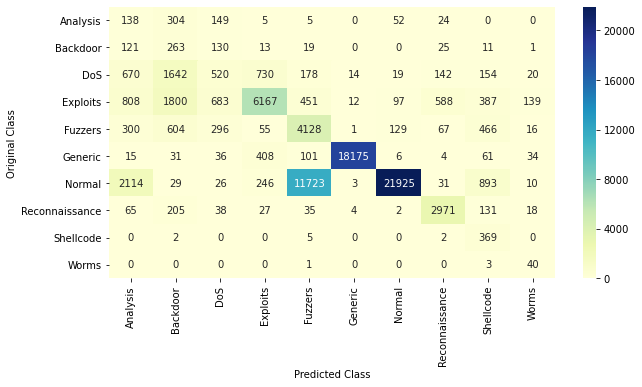

-------------------------------------------------- Precision matrix --------------------------------------------------


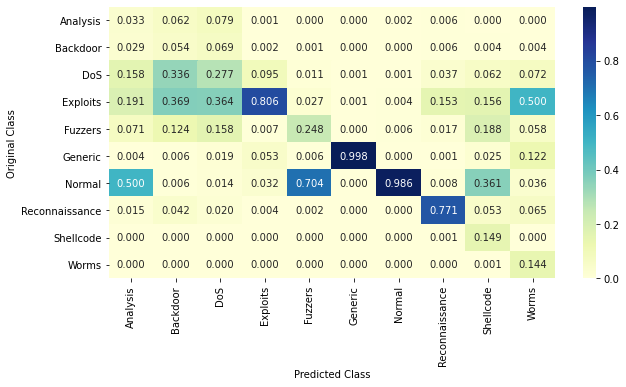

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


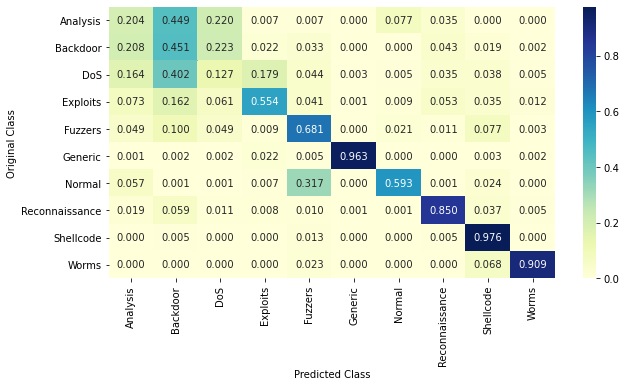

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [39]:
plot_confusion_matrix(y_test, oxgb_balanced.predict(X_test_encoded.todense()))

In [40]:
with open("oxgb_models", "wb") as fp:   #Pickling
    pickle.dump(oxgb_balanced.ovr_models, fp)

#### 2. Neural Network based OneVsRest Model

In [41]:
"""
    One Vs Rest model based on Neural network
"""
class OvrNeural:

    """
        constructor
    """
    def __init__(self):
        self.ovr_models = dict()
        self.weight = dict()
        for i in range(10):
            self.weight[i] = 1
            
    
    """
        set new weights
    """
    def set_weight(self, new_weight):
        self.weight = new_weight
    
    
    """
        train model and validate
    """
    def fit(self, train_x, train_y, val_x, val_y, balance=False):
        ovr_classes = np.unique(train_y)
        print('Training...')
        for ovr_class in ovr_classes:
            self.__fit_class(ovr_class, train_x, train_y, val_x, val_y, balance)


    """
        internal method
    """
    def __fit_class(self, ovr_class, train_x, train_y, val_x, val_y, balance):
        #train_y_ovr = np.array([1 if y == ovr_class else 0 for y in train_y])
        train_y_ovr = []
        val_y_ovr = np.array([1 if y == ovr_class else 0 for y in val_y])

        #classes of value 1 will be quite less since all other classes will get covered under 0. this might create imbalanced training set
        #generating a balanced training and val subset
        train_mask = []
        val_mask = []

        ovr_class_count = 0
        non_ovr_class_count = 0
        for index, y in enumerate(train_y):
            if y == ovr_class:   #if current class then add directly
                train_mask.append(index)
                train_y_ovr.append(1)
                ovr_class_count+=1
            elif not balance: #if not balance then add directly else add only if balanced
                train_mask.append(index)
                train_y_ovr.append(0)
                non_ovr_class_count+=1
            elif ovr_class_count >= non_ovr_class_count:
                train_mask.append(index)
                train_y_ovr.append(0)
                non_ovr_class_count+=1
        
        model = Sequential()
        model.add(Dense(1024, activation='relu', input_dim=train_x.shape[1]))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=0, patience=25)

        model.fit(train_x[train_mask], np.array(train_y_ovr), batch_size=64, epochs=100, validation_data=(val_x, val_y_ovr), verbose=0, callbacks=[es])
        
        self.ovr_models[ovr_class] = model #store OVR model

        train_ovr_detection_acc = self.__get_acc(train_y_ovr, [int(np.round(x)) for x in model.predict(train_x[train_mask])])
        val_ovr_detection_acc = self.__get_acc(val_y_ovr, [int(np.round(x)) for x in model.predict(val_x)])

        print('Accuracy for class "' + str(y_encoder.classes_[ovr_class]) + '" - Train acc.: ' + str(train_ovr_detection_acc) + ' %, Val acc.: ' + str(val_ovr_detection_acc) + ' %')


    """
        get accuracy
    """
    def __get_acc(self, true_y, pred_y):
        return round(accuracy_score(true_y, pred_y) * 100, 2)

    """
        get auc score
    """
    def __get_auc(self, true_y, pred_y):
        return round(roc_auc_score(true_y, pred_y) * 100, 2)


    """
        predict test X
    """
    def predict(self, test_x):
        ovr_pred = np.array([])  #for storing predictions
        ovr_proba = np.array([]) #for storing probabilities
        for ovr_class in np.unique(y_train):

            if ovr_class==0:
                ovr_pred, ovr_proba = self.__predict_using_ovr(ovr_class, test_x)
                ovr_proba = ovr_proba * self.weight[ovr_class]
            else:
                pred, proba = self.__predict_using_ovr(ovr_class, test_x)
                proba = proba * self.weight[ovr_class]

                ovr_pred = np.hstack((ovr_pred, pred))
                ovr_proba = np.hstack((ovr_proba, proba))

        result = []
        for index, pred_row in enumerate(ovr_pred):
            #if single prediction is present across all predictions go for this value otherwise use probabilites
            if np.bincount(pred_row.astype(int), minlength=2)[1] == 1:
                result.append(np.argmax(ovr_pred[index]))
            else:
                result.append(np.argmax(ovr_proba[index]))

        return np.array(result)
    
    
    """
        predict proba
    """
    def predict_proba(self, test_x):
        ovr_pred = np.array([])  #for storing predictions
        ovr_proba = np.array([]) #for storing probabilities
        for ovr_class in np.unique(y_train):

            if ovr_class==0:
                ovr_pred, ovr_proba = self.__predict_using_ovr(ovr_class, test_x)
                ovr_proba = ovr_proba * self.weight[ovr_class]
            else:
                pred, proba = self.__predict_using_ovr(ovr_class, test_x)
                proba = proba * self.weight[ovr_class]

                ovr_pred = np.hstack((ovr_pred, pred))
                ovr_proba = np.hstack((ovr_proba, proba))

        return ovr_proba

    """
        utility method
    """
    def __predict_using_ovr(self, ovr_class, test_x):
        ovr_model = self.ovr_models[ovr_class]

        """
            use predict
            if it fails then use proba
        """
        pred = ovr_model.predict(test_x)
        proba = ovr_model.predict_proba(test_x) #use for keras models
        #proba = ovr_model.predict_proba(test_x)[:, 1] #use for xgb
        return pred.reshape(-1, 1), proba.reshape(-1, 1)


__OVR Neural Network WITHOUT class balancing__

In [42]:
ovrn = OvrNeural()
ovrn.fit(X_train_encoded.todense(), y_train, X_cv_encoded.todense(), y_cv, False) #trying without balancing
model_attack_cat['ovrn'] = ovrn

Training...
Accuracy for class "Analysis" - Train acc.: 92.9 %, Val acc.: 91.6 %
Accuracy for class "Backdoor" - Train acc.: 92.2 %, Val acc.: 90.83 %
Accuracy for class "DoS" - Train acc.: 91.39 %, Val acc.: 89.42 %
Accuracy for class "Exploits" - Train acc.: 94.6 %, Val acc.: 93.23 %
Accuracy for class "Fuzzers" - Train acc.: 97.69 %, Val acc.: 96.0 %
Accuracy for class "Generic" - Train acc.: 99.82 %, Val acc.: 99.8 %
Accuracy for class "Normal" - Train acc.: 98.05 %, Val acc.: 98.07 %
Accuracy for class "Reconnaissance" - Train acc.: 97.7 %, Val acc.: 96.6 %
Accuracy for class "Shellcode" - Train acc.: 99.12 %, Val acc.: 98.33 %
Accuracy for class "Worms" - Train acc.: 99.9 %, Val acc.: 99.67 %


In [43]:
predict_y = ovrn.predict_proba(X_train_encoded.todense())
print ('log loss for train data', (log_loss(y_train, predict_y)))
predict_y = ovrn.predict_proba(X_cv_encoded.todense())
print ('log loss for cv data', (log_loss(y_cv, predict_y)))
predict_y = ovrn.predict_proba(X_test_encoded.todense())
print ('log loss for test data', (log_loss(y_test, predict_y)))

log loss for train data 0.505105004632244
log loss for cv data 1.1892232977748987
log loss for test data 1.688289293107812


Number of misclassified points  34.459262498178106
-------------------------------------------------- Confusion matrix --------------------------------------------------


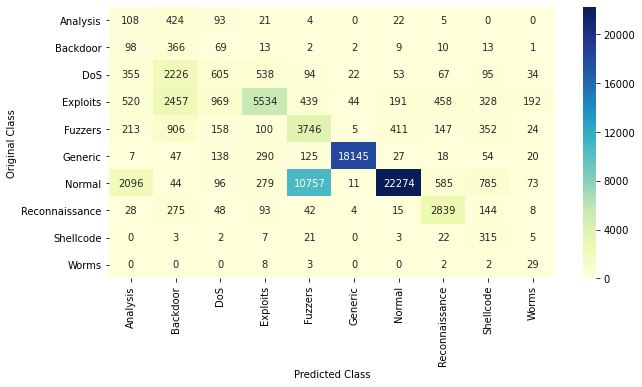

-------------------------------------------------- Precision matrix --------------------------------------------------


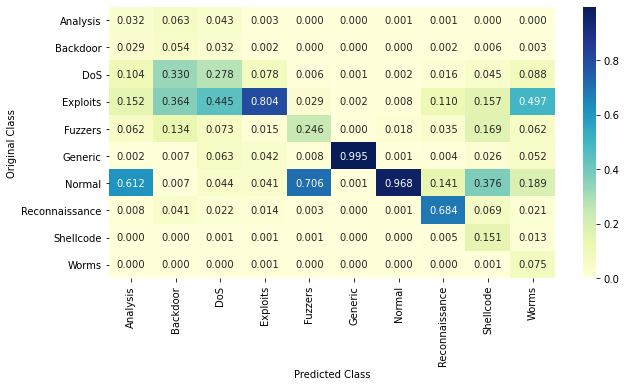

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


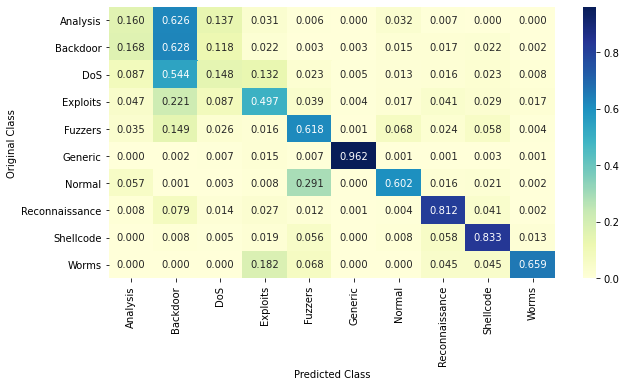

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [44]:
plot_confusion_matrix(y_test, ovrn.predict(X_test_encoded.todense()))

In [45]:
ovrn_balanced = OvrNeural()
ovrn_balanced.fit(X_train_encoded.todense(), y_train, X_cv_encoded.todense(), y_cv, True) #trying with balancing
model_attack_cat['ovrn_balanced'] = ovrn_balanced

Training...
Accuracy for class "Analysis" - Train acc.: 90.2 %, Val acc.: 79.43 %
Accuracy for class "Backdoor" - Train acc.: 90.88 %, Val acc.: 77.25 %
Accuracy for class "DoS" - Train acc.: 85.85 %, Val acc.: 73.63 %
Accuracy for class "Exploits" - Train acc.: 84.99 %, Val acc.: 69.93 %
Accuracy for class "Fuzzers" - Train acc.: 94.62 %, Val acc.: 90.17 %
Accuracy for class "Generic" - Train acc.: 99.3 %, Val acc.: 99.17 %
Accuracy for class "Normal" - Train acc.: 98.05 %, Val acc.: 94.1 %
Accuracy for class "Reconnaissance" - Train acc.: 92.73 %, Val acc.: 90.43 %
Accuracy for class "Shellcode" - Train acc.: 98.97 %, Val acc.: 95.82 %
Accuracy for class "Worms" - Train acc.: 99.43 %, Val acc.: 97.75 %


In [46]:
predict_y = ovrn_balanced.predict_proba(X_train_encoded.todense())
print ('log loss for train data', (log_loss(y_train, predict_y)))
predict_y = ovrn_balanced.predict_proba(X_cv_encoded.todense())
print ('log loss for cv data', (log_loss(y_cv, predict_y)))
predict_y = ovrn_balanced.predict_proba(X_test_encoded.todense())
print ('log loss for test data', (log_loss(y_test, predict_y)))

log loss for train data 0.7563847944201455
log loss for cv data 1.046439907205388
log loss for test data 1.1851513142810366


Number of misclassified points  35.998153816256135
-------------------------------------------------- Confusion matrix --------------------------------------------------


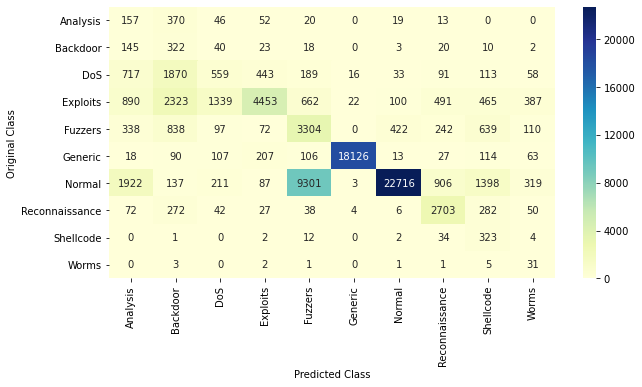

-------------------------------------------------- Precision matrix --------------------------------------------------


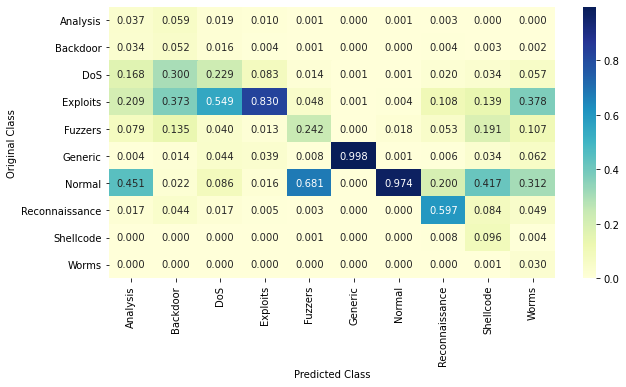

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


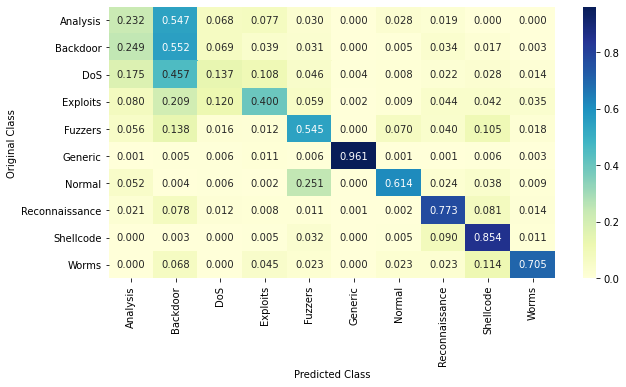

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [47]:
plot_confusion_matrix(y_test, ovrn_balanced.predict(X_test_encoded.todense()))

## Using OneVsRest ( XGBoost based ) model with reduced number of features 

### OneVsRest with Classwise K-Best Features

In [48]:

class OvrXgbKBest:

    def __init__(self):
        self.ovr_models = dict()
        self.best_feature_selectors = dict()
        self.weight = dict()
        for i in range(10):
            self.weight[i] = 1
            
    """
        set new weights
    """
    def set_weight(self, new_weight):
        self.weight = new_weight
    
    """
        train model and validate
    """
    def fit(self, train_x, train_y, val_x, val_y, balance=False):
        ovr_classes = np.unique(train_y)
        print('Training...')
        for ovr_class in ovr_classes:
            self.__fit_class(ovr_class, train_x, train_y, val_x, val_y, balance)


    def __fit_class(self, ovr_class, train_x, train_y, val_x, val_y, balance):
        #train_y_ovr = np.array([1 if y == ovr_class else 0 for y in train_y])
        train_y_ovr = []
        val_y_ovr = np.array([1 if y == ovr_class else 0 for y in val_y])

        #classes of value 1 will be quite less since all other classes will get covered under 0. this might create imbalanced training set
        #generating a balanced training and val subset
        train_mask = []
        val_mask = []

        ovr_class_count = 0
        non_ovr_class_count = 0
        for index, y in enumerate(train_y):
            if y == ovr_class:   #if current class then add directly
                train_mask.append(index)
                train_y_ovr.append(1)
                ovr_class_count+=1
            elif not balance: #if not balance then add directly else add only if balanced
                train_mask.append(index)
                train_y_ovr.append(0)
                non_ovr_class_count+=1
            elif ovr_class_count >= non_ovr_class_count:
                train_mask.append(index)
                train_y_ovr.append(0)
                non_ovr_class_count+=1
                
        
        """
        score all features
        """
        skb = SelectKBest(k='all').fit(train_x[train_mask], train_y_ovr)    
        scores = np.array(skb.scores_)
        
        #find number of features whose score is greater than atleast half of mean scores
        num_k = scores[scores>=scores.mean()/2].shape[0]
        
        class_best_feature_selector = SelectKBest(k=num_k).fit(train_x[train_mask], train_y_ovr)
        
        #generate train_x and val_x with best features
        train_x = class_best_feature_selector.transform(train_x[train_mask])
        val_x = class_best_feature_selector.transform(val_x)
        
        x_cfl=XGBClassifier(nthread=4)
        x_cfl.fit(train_x, train_y_ovr)

        model = CalibratedClassifierCV(x_cfl, method="sigmoid")
        model.fit(train_x, train_y_ovr)
        
        self.ovr_models[ovr_class] = model #store OVR model
        self.best_feature_selectors[ovr_class] = class_best_feature_selector #store feature selector

        train_ovr_detection_acc = self.__get_acc(train_y_ovr, [int(np.round(x)) for x in model.predict(train_x)])
        val_ovr_detection_acc = self.__get_acc(val_y_ovr, [int(np.round(x)) for x in model.predict(val_x)])

        print('Accuracy for class "' + str(y_encoder.classes_[ovr_class]) + '"' + ' with ' + str(train_x.shape[1]) +  ' features - Train acc.: ' + str(train_ovr_detection_acc) + ' %, Val acc.: ' + str(val_ovr_detection_acc) + ' %')

        

    """
        get accuracy
    """
    def __get_acc(self, true_y, pred_y):
        return round(accuracy_score(true_y, pred_y) * 100, 2)

    """
        get auc score
    """
    def __get_auc(self, true_y, pred_y):
        return round(roc_auc_score(true_y, pred_y) * 100, 2)


    """
        predict test X
    """
    def predict(self, test_x_all_features):
        ovr_pred = np.array([])  #for storing predictions
        ovr_proba = np.array([]) #for storing probabilities
        for ovr_class in np.unique(y_train):
            
            #select k best features
            test_x = self.best_feature_selectors[ovr_class].transform(test_x_all_features)
            
            if ovr_class==0:
                ovr_pred, ovr_proba = self.__predict_using_ovr(ovr_class, test_x)
                ovr_proba = ovr_proba * self.weight[ovr_class]
            else:
                pred, proba = self.__predict_using_ovr(ovr_class, test_x)
                proba = proba * self.weight[ovr_class]

                ovr_pred = np.hstack((ovr_pred, pred))
                ovr_proba = np.hstack((ovr_proba, proba))

        result = []
        for index, pred_row in enumerate(ovr_pred):
            #if single prediction is present across all predictions go for this value otherwise use probabilites
            if np.bincount(pred_row.astype(int), minlength=2)[1] == 1:
                result.append(np.argmax(ovr_pred[index]))
            else:
                result.append(np.argmax(ovr_proba[index]))

        return np.array(result)
    
    
    """
        predict probability
    """
    def predict_proba(self, test_x_all_features):
        ovr_pred = np.array([])  #for storing predictions
        ovr_proba = np.array([]) #for storing probabilities
        for ovr_class in np.unique(y_train):
            
            #select k best features
            test_x = self.best_feature_selectors[ovr_class].transform(test_x_all_features)
            
            if ovr_class==0:
                ovr_pred, ovr_proba = self.__predict_using_ovr(ovr_class, test_x)
                ovr_proba = ovr_proba * self.weight[ovr_class]
            else:
                pred, proba = self.__predict_using_ovr(ovr_class, test_x)
                proba = proba * self.weight[ovr_class]

                ovr_pred = np.hstack((ovr_pred, pred))
                ovr_proba = np.hstack((ovr_proba, proba))

        return ovr_proba

    """
        utility method
    """
    def __predict_using_ovr(self, ovr_class, test_x):
        ovr_model = self.ovr_models[ovr_class]

        """
            use predict
            if it fails then use proba
        """
        pred = ovr_model.predict(test_x)
        #proba = ovr_model.predict_proba(test_x) #use for keras models
        proba = ovr_model.predict_proba(test_x)[:, 1] #use for xgb
        return pred.reshape(-1, 1), proba.reshape(-1, 1)


In [49]:
ovr_xgb_kbest = OvrXgbKBest()
ovr_xgb_kbest.fit(X_train_encoded.todense(), y_train, X_cv_encoded.todense(), y_cv, False)
model_attack_cat['ovr_xgb_kbest'] = ovr_xgb_kbest

Training...
Accuracy for class "Analysis" with 43 features - Train acc.: 92.53 %, Val acc.: 91.77 %
Accuracy for class "Backdoor" with 42 features - Train acc.: 90.89 %, Val acc.: 91.22 %
Accuracy for class "DoS" with 42 features - Train acc.: 90.16 %, Val acc.: 89.77 %
Accuracy for class "Exploits" with 39 features - Train acc.: 92.88 %, Val acc.: 93.0 %
Accuracy for class "Fuzzers" with 32 features - Train acc.: 94.52 %, Val acc.: 95.28 %
Accuracy for class "Generic" with 20 features - Train acc.: 99.76 %, Val acc.: 99.82 %
Accuracy for class "Normal" with 32 features - Train acc.: 97.97 %, Val acc.: 98.13 %
Accuracy for class "Reconnaissance" with 41 features - Train acc.: 97.36 %, Val acc.: 97.15 %
Accuracy for class "Shellcode" with 34 features - Train acc.: 95.48 %, Val acc.: 95.6 %
Accuracy for class "Worms" with 33 features - Train acc.: 99.65 %, Val acc.: 99.65 %


In [50]:
predict_y = ovr_xgb_kbest.predict_proba(X_train_encoded.todense())
print ('log loss for train data', (log_loss(y_train, predict_y)))
predict_y = ovr_xgb_kbest.predict_proba(X_cv_encoded.todense())
print ('log loss for cv data', (log_loss(y_cv, predict_y)))
predict_y = ovr_xgb_kbest.predict_proba(X_test_encoded.todense())
print ('log loss for test data', (log_loss(y_test, predict_y)))

log loss for train data 0.8077533555391351
log loss for cv data 0.8198103020483526
log loss for test data 1.0212454423895354


Number of misclassified points  33.302968469125005
-------------------------------------------------- Confusion matrix --------------------------------------------------


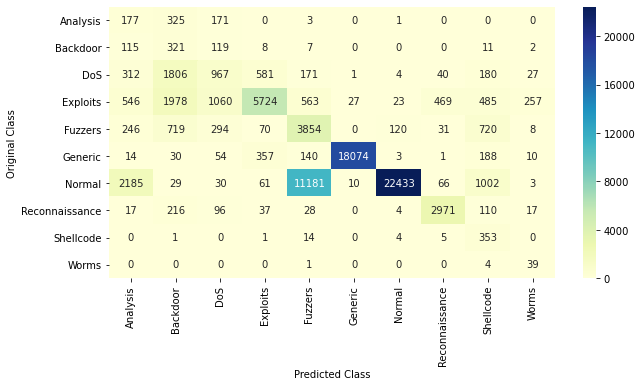

-------------------------------------------------- Precision matrix --------------------------------------------------


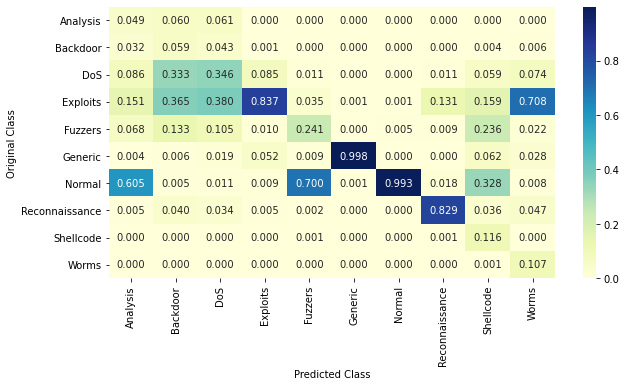

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


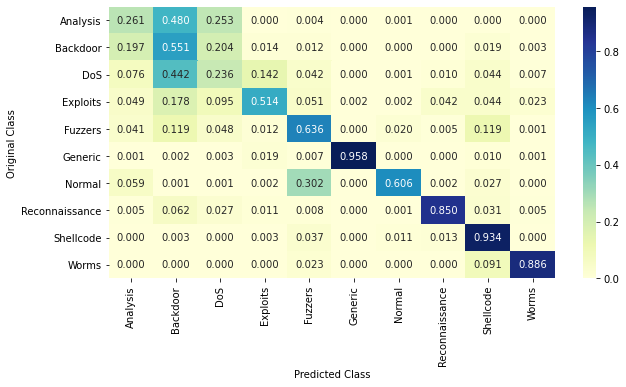

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [51]:
plot_confusion_matrix(y_test, ovr_xgb_kbest.predict(X_test_encoded.todense()))

### OneVsRest ( With Only 39 Numerical/Binary Features )

In [52]:
def merge_all_numerical_binary(features, scaled_features, binary_features):
    #merging all vectorized features
    features_encoded = np.array([])
    count = 1

    features_encoded_name = []
    #merging numerical features
    for k in scaled_features.keys():
        if features_encoded.shape[0]==0:
            features_encoded = scaled_features[k]
        else:    
            features_encoded = np.hstack((features_encoded, scaled_features[k]))
        
        features_encoded_name.append(k)
            #print(str(count) + '. hstack ' + str(k) + ', shape - ' + str(scaled_features[k].shape) + ', features_encoded shape: ' + str(features_encoded.shape) + ', features_encoded_name len: ' + str(len(features_encoded_name)))
        count+=1

    #merging binary features
    for k in binary_features:
        if k =='label': #ignore label and attack category
            continue

        features_encoded = hstack((features_encoded, csr_matrix(features[k].values.reshape(-1, 1))))    
        features_encoded_name.append(k)
        #print(str(count) + '. hstack ' + str(k) + ', shape - ' + str(features[k].values.reshape(-1, 1).shape) + ', features_encoded shape: ' + str(features_encoded.shape) + ', features_encoded_name len: ' + str(len(features_encoded_name)))
        count+=1
    
    print('features_encoded shape: ' + str(features_encoded.shape) + ', features_encoded_name len: ' + str(len(features_encoded_name)))
    return features_encoded, features_encoded_name


In [64]:
X_train_encoded_bn, X_train_encoded_features_bn = merge_all_numerical_binary(X_train, get_standardized_features(X_train, numerical_features, feature_standardizers), binary_features)
X_cv_encoded_bn, _ = merge_all_numerical_binary(X_cv, get_standardized_features(X_cv, numerical_features, feature_standardizers), binary_features)
X_test_encoded_bn, _ = merge_all_numerical_binary(X_test, get_standardized_features(X_test, numerical_features, feature_standardizers), binary_features)

features_encoded shape: (24000, 39), features_encoded_name len: 39
features_encoded shape: (6000, 39), features_encoded_name len: 39
features_encoded shape: (82332, 39), features_encoded_name len: 39


In [65]:
X_train_encoded_bn.shape

(24000, 39)

In [66]:
ovr_xgb_num_bin_features = OvrXgb()
ovr_xgb_num_bin_features.fit(X_train_encoded_bn.todense(), y_train, X_cv_encoded_bn.todense(), y_cv, False)
model_attack_cat['ovr_xgb_num_bin_features'] = ovr_xgb_num_bin_features

Training...
Accuracy for class "Analysis" - Train acc.: 92.83 %, Val acc.: 92.07 %
Accuracy for class "Backdoor" - Train acc.: 91.62 %, Val acc.: 91.22 %
Accuracy for class "DoS" - Train acc.: 90.92 %, Val acc.: 89.65 %
Accuracy for class "Exploits" - Train acc.: 93.42 %, Val acc.: 93.42 %
Accuracy for class "Fuzzers" - Train acc.: 96.5 %, Val acc.: 96.35 %
Accuracy for class "Generic" - Train acc.: 99.89 %, Val acc.: 99.82 %
Accuracy for class "Normal" - Train acc.: 98.58 %, Val acc.: 98.07 %
Accuracy for class "Reconnaissance" - Train acc.: 97.6 %, Val acc.: 97.32 %
Accuracy for class "Shellcode" - Train acc.: 98.78 %, Val acc.: 98.5 %
Accuracy for class "Worms" - Train acc.: 99.99 %, Val acc.: 99.95 %


In [67]:
predict_y = ovr_xgb_num_bin_features.predict_proba(X_train_encoded_bn.todense())
print ('log loss for train data', (log_loss(y_train, predict_y)))
predict_y = ovr_xgb_num_bin_features.predict_proba(X_cv_encoded_bn.todense())
print ('log loss for cv data', (log_loss(y_cv, predict_y)))
predict_y = ovr_xgb_num_bin_features.predict_proba(X_test_encoded_bn.todense())
print ('log loss for test data', (log_loss(y_test, predict_y)))

log loss for train data 0.6734110149035522
log loss for cv data 0.7558187916736772
log loss for test data 1.01598842975531


Number of misclassified points  32.97138415197007
-------------------------------------------------- Confusion matrix --------------------------------------------------


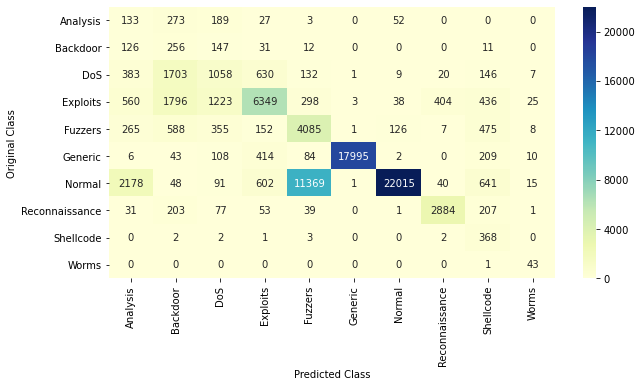

-------------------------------------------------- Precision matrix --------------------------------------------------


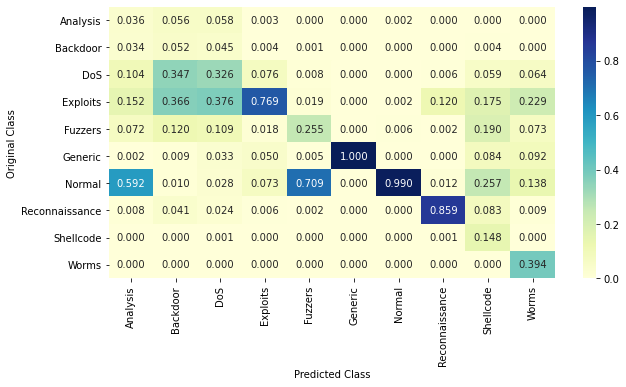

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


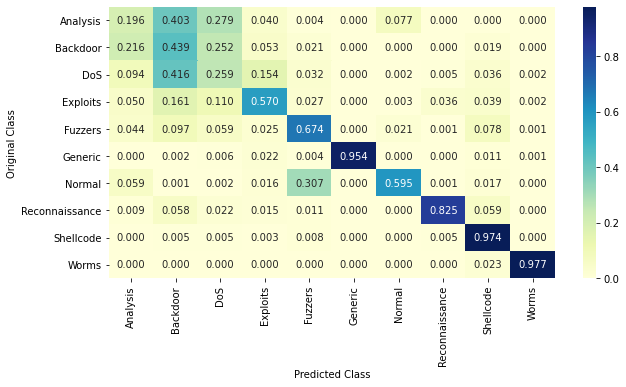

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [68]:
plot_confusion_matrix(y_test, ovr_xgb_num_bin_features.predict(X_test_encoded_bn.todense()))

### XGBoost ( With 39 Numerical/Binary Features )

100%|████████████████████████████████████████████████████████████████████████████████| 7/7 [2:01:30<00:00, 1041.50s/it]


log_loss for c =  10 is 0.9948878377471424
log_loss for c =  50 is 0.8507931638317612
log_loss for c =  100 is 0.8024318190691595
log_loss for c =  500 is 0.740439626909257
log_loss for c =  1000 is 0.7416106401239883
log_loss for c =  2000 is 0.7557006250834726
log_loss for c =  3000 is 0.7668297339507344


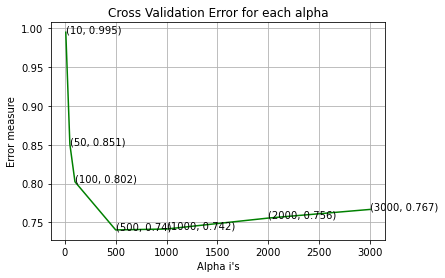

In [69]:
alpha=[10, 50, 100, 500, 1000, 2000, 3000]
cv_log_error_array=[]
for i in tqdm(alpha):
    x_cfl=XGBClassifier(n_estimators=i, nthread=4)
    x_cfl.fit(X_train_encoded_bn, y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_encoded_bn, y_train)
    predict_y = sig_clf.predict_proba(X_cv_encoded_bn)
    cv_log_error_array.append(log_loss(y_cv, predict_y))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
    
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [70]:
x_cfl=XGBClassifier(n_estimators=alpha[best_alpha], nthread=4)
x_cfl.fit(X_train_encoded_bn,y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_encoded_bn, y_train)
    
predict_y = sig_clf.predict_proba(X_train_encoded_bn)

print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv_encoded_bn)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:", log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test_encoded_bn)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y))

#storing trained model
model_attack_cat['xgb_num_bin'] = sig_clf

For values of best alpha =  500 The train log loss is: 0.6333985866709981
For values of best alpha =  500 The cross validation log loss is: 0.740439626909257
For values of best alpha =  500 The test log loss is: 1.0370901269568527


Number of misclassified points  32.681096050138464
-------------------------------------------------- Confusion matrix --------------------------------------------------


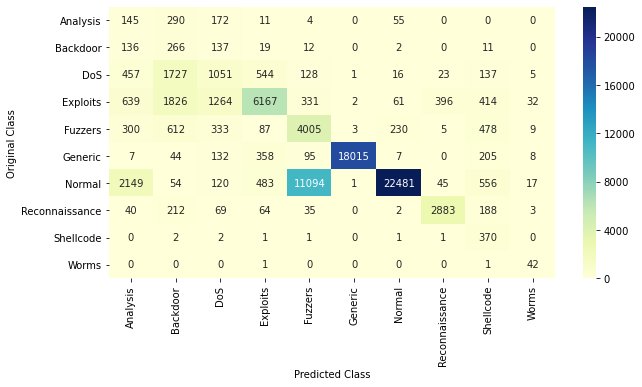

-------------------------------------------------- Precision matrix --------------------------------------------------


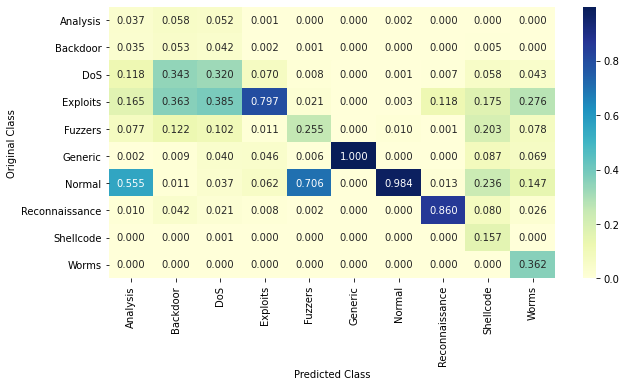

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


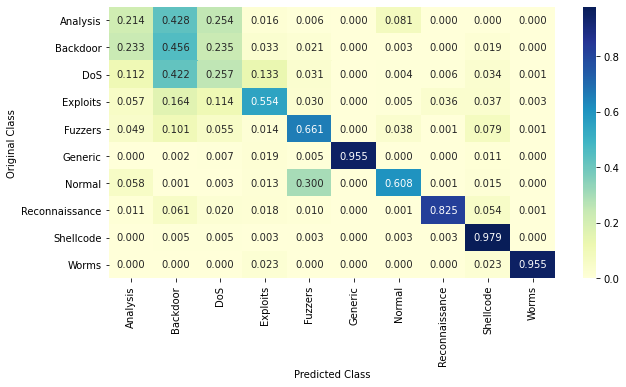

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [71]:
plot_confusion_matrix(y_test, sig_clf.predict(X_test_encoded_bn))

#### Summary Table for Attack Classification

In [72]:
count = 1
models = ['knn', 'lr', 'rf', 'xgb', 'dt', 'nn', 
          'oxgb', 'oxgb_balanced', 'ovrn', 'ovrn_balanced', 
          'ovr_xgb_kbest', 'ovr_xgb_num_bin_features', 'xgb_num_bin']

model_names = {'knn':'K Nearest Neighbours', 
               'lr':'Logistic Regression', 
               'rf':'Random Forest', 'xgb':'XGBoost', 
               'nb':'Naive Bayes', 'dt':'Decision Tree', 
               'nn':'Neural Network', 
               'oxgb':'OneVsRest - XGBoost', 
               'oxgb_balanced':'OneVsRest - XGBoost ( Balanced )', 
               'ovrn':'OneVsRest - Neural Network', 
               'ovrn_balanced':'OneVsRest - Neural Network ( Balanced)',
               'ovr_xgb_kbest':'OVR - XGBoost ( With class-wise K best features )',
               'ovr_xgb_num_bin_features': 'OVR - XGBoost ( With num/binary features )',
               'xgb_num_bin':'XGBoost ( With num/binary features )'}

summary_table = PrettyTable()
summary_table_columns = ['Sr. No.', 'Classifier', 'Log Loss',  'Overall Accuracy']
summary_table_columns.extend(y_encoder.classes_)

summary_table.field_names = summary_table_columns

for count, model in enumerate(models, start=1):
    if model == 'nn':
        y_pred = [np.argmax(x) for x in model_attack_cat[model].predict(X_test_encoded.todense())]
        y_proba = [x for x in model_attack_cat[model].predict(X_test_encoded.todense())]
    elif model == 'ovr_xgb_num_bin_features' or model == 'xgb_num_bin': # for numberical binary features
        y_pred = model_attack_cat[model].predict(X_test_encoded_bn)
        y_proba = model_attack_cat[model].predict_proba(X_test_encoded_bn)
    elif model == 'ovrn' or model == 'ovrn_balanced':
        y_pred = model_attack_cat[model].predict(X_test_encoded.todense())
        y_proba = model_attack_cat[model].predict_proba(X_test_encoded.todense())
    else:
        y_pred = model_attack_cat[model].predict(X_test_encoded)
        y_proba = model_attack_cat[model].predict_proba(X_test_encoded)
        
    C = confusion_matrix(y_test, y_pred)
    A = (((C.T)/(C.sum(axis=1))).T)    
    
    ada = [str(str(round(A[i][i] * 100, 2)) + ' %') for i in range(10)]
        
    row = [str(count), 
           str(model_names[model]), 
           str(round(log_loss(y_test, y_proba), 4)), 
           str(round(accuracy_score(y_test, y_pred) * 100, 2)) + ' %']
    
    row.extend(ada)
    
    summary_table.add_row(row)
    
print(summary_table)

+---------+---------------------------------------------------+----------+------------------+----------+----------+---------+----------+---------+---------+---------+----------------+-----------+---------+
| Sr. No. |                     Classifier                    | Log Loss | Overall Accuracy | Analysis | Backdoor |   DoS   | Exploits | Fuzzers | Generic |  Normal | Reconnaissance | Shellcode |  Worms  |
+---------+---------------------------------------------------+----------+------------------+----------+----------+---------+----------+---------+---------+---------+----------------+-----------+---------+
|    1    |                K Nearest Neighbours               |  1.3095  |     62.69 %      | 19.35 %  | 35.68 %  | 13.84 % | 47.42 %  | 55.44 % | 92.73 % | 60.32 % |    57.72 %     |   58.2 %  | 29.55 % |
|    2    |                Logistic Regression                |  1.4851  |     53.26 %      | 45.94 %  | 38.25 %  |  0.42 % | 47.13 %  | 30.19 % | 91.28 % | 49.79 % |     5.01 

In [62]:
# cannot save keras model. We get an exception. Saving other models.
"""model_attack_cat['nn'] = None
model_attack_cat['ovrn'] = None
model_attack_cat['ovrn_balanced'] = None

with open("nac_models", "wb") as fp:   #Pickling
    pickle.dump(model_attack_cat, fp)
    """

'model_attack_cat[\'nn\'] = None\nmodel_attack_cat[\'ovrn\'] = None\nmodel_attack_cat[\'ovrn_balanced\'] = None\n\nwith open("nac_models", "wb") as fp:   #Pickling\n    pickle.dump(model_attack_cat, fp)\n    '